# Importing necessary libraries

In [1]:
###################################### Python Basic Libraries      #######################################

import random
import math


##################################### Basic Data Science Libraries ###################################

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as mpatches
import seaborn as sns

from numpy.random import seed
from numpy.random import randn

#from scipy import stats
from pylab import rcParams
#from statsmodels.graphics.gofplots import qqplot


################################### Machine Learning Libraries ####################################

#from sklearn.linear_model import LogisticRegression
#from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing   import StandardScaler
from sklearn.preprocessing   import Normalizer
#from sklearn.multiclass import OneVsRestClassifier
#from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPClassifier


################################### Geospatial Data Science Libraries #######################################

import geopandas as gpd
import geoplot  as gplt

"""
#from matplotlib import pyplot
import shapely.geometry as sgeom
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import cartopy.feature as cfeature
import pyproj
""";

# Optional Setting of the Style for the Jupyter Notebook 

In [2]:
plt.style.use('seaborn-dark')
#from jupyterthemes import jtplot
#jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)
pd.set_option("display.max_rows", 1000)

# Reading in  the data 

In [3]:
df = pd.read_csv("US_Accidents_Dec20.csv")

# 1 Bussiness Questions

- What kind of facilities/neighbourhood characterizes the accidents' hot spots? Where are the hot spots?
- Which roads seem to be most dangerous?

<br>*I will try to answer this questions with help of decriptive statistics*<br><br>

- Which variables have influece on severity of an accident? Possible ML model to predict it
- Would it be possible to train a model which could predict the duration of emergency works required at the place of accident (in minutes)

<br>*I will try to answer this questions with the help of inference (in this case machine learning models)*<br>

# 2 Overview and basic check of the data. Dealing with the null values

In [4]:
df.head()

,ID,Source,TMC,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-1,MapQuest,201.0,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865147,-84.058723,NaN,NaN,...,False,False,False,False,False,False,Night,Night,Night,Night
1,A-2,MapQuest,201.0,2,2016-02-08 06:07:59,2016-02-08 06:37:59,39.928059,-82.831184,NaN,NaN,...,False,False,False,False,False,False,Night,Night,Night,Day
2,A-3,MapQuest,201.0,2,2016-02-08 06:49:27,2016-02-08 07:19:27,39.063148,-84.032608,NaN,NaN,...,False,False,False,False,True,False,Night,Night,Day,Day
3,A-4,MapQuest,201.0,3,2016-02-08 07:23:34,2016-02-08 07:53:34,39.747753,-84.205582,NaN,NaN,...,False,False,False,False,False,False,Night,Day,Day,Day
4,A-5,MapQuest,201.0,2,2016-02-08 07:39:07,2016-02-08 08:09:07,39.627781,-84.188354,NaN,NaN,...,False,False,False,False,True,False,Day,Day,Day,Day


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4232541 entries, 0 to 4232540
Data columns (total 49 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   ID                     object 
 1   Source                 object 
 2   TMC                    float64
 3   Severity               int64  
 4   Start_Time             object 
 5   End_Time               object 
 6   Start_Lat              float64
 7   Start_Lng              float64
 8   End_Lat                float64
 9   End_Lng                float64
 10  Distance(mi)           float64
 11  Description            object 
 12  Number                 float64
 13  Street                 object 
 14  Side                   object 
 15  City                   object 
 16  County                 object 
 17  State                  object 
 18  Zipcode                object 
 19  Country                object 
 20  Timezone               object 
 21  Airport_Code           object 
 22  Weather_Timestamp 

#### There is a mistake I have noticed during primary analysis of the given data. I would like to fix this issue just at the begining of the following notebook. It is quite important for the further steps especially when I will use the "get_dummies" function with "drop_first" parameter

In [6]:
df.Side.value_counts() # One record without defined side

R    3467079
L     765461
           1
Name: Side, dtype: int64

In [7]:
df = df.loc[(df.Side == "R") | (df.Side == "L")]

In [8]:
df.Side.value_counts() #Issue fixed

R    3467079
L     765461
Name: Side, dtype: int64

## Getting rid of constant features

In [9]:
for column in df:
    if len(df[column].value_counts()) < 2:
        print("dropping:", column)
        df.drop(axis = 1, columns = [column], inplace = True)

dropping: Country
dropping: Turning_Loop


## Checking the ID column for uniqueness of data

In [10]:
if df.ID.duplicated().mean() == 0:
    print("The data is unique")
else:
    print("We have duplicated in the id column!")

The data is unique


## Checking the data for its completness

In [11]:
def show_incomplete_data(data_frame, threshold = 1):
    return (data_frame.notnull().sum() / len(data_frame)).loc[
    (data_frame.notnull().sum() / len(df) < threshold)].sort_values()

In [12]:
show_incomplete_data(df)

End_Lat                  0.358192
End_Lng                  0.358192
Number                   0.364932
Precipitation(in)        0.511974
Wind_Chill(F)            0.552042
TMC                      0.641808
Wind_Speed(mph)          0.886752
Visibility(mi)           0.976688
Weather_Condition        0.976756
Humidity(%)              0.977445
Temperature(F)           0.978760
Wind_Direction           0.980246
Pressure(in)             0.981953
Weather_Timestamp        0.985199
Airport_Code             0.997880
Timezone                 0.998910
Zipcode                  0.999695
Nautical_Twilight        0.999967
Sunrise_Sunset           0.999967
Civil_Twilight           0.999967
Astronomical_Twilight    0.999967
City                     0.999968
Description              1.000000
dtype: float64

#### As depicted in the cell above, we are missing some data. However some columns are almost complete. Since the data set is huge, I have decided to set the threshold of 85% for the definition of data completness

In [13]:
show_incomplete_data(df, .85)

End_Lat              0.358192
End_Lng              0.358192
Number               0.364932
Precipitation(in)    0.511974
Wind_Chill(F)        0.552042
TMC                  0.641808
dtype: float64

- **The columns *`End_Lat`*, *`End_Lng`* are not necessary for answering posed questions. One could say that together with *`Start_Lat`*, *`Start_Lng`* it would be possible to make feature engineering and provide the impact area of an accident. However, there is already a column describing it (although 1 dimensionally but still sufficiently good in terms of traffic) - the length of the road extent affected by the accident - column *`Distance(mi)`***
<br>

- **The *`Number`* column indicates the house number provided in the adress field in the report of an accident. This column is also not necessary for answering posed questions or could even potentially overfit the data while using ML models.**
<br>

- **The columns *`Wind_Chill`* and *`Precipitation`* will be filled with using analytical approaches or dropped provided that there are some strong correlations with other features**
<br>

- **The column *`TMC`* will be reengineered and simplified. For now in this column one can distinguish the channel number used for accident description. For the purposes of the given tasks it will be simplified to the statement whether the message was sent or not**
<br>



#### Dropping "Number, "End_Lat", "End_Lng"

In [14]:
df.drop(axis = 1, columns = ["Number", "End_Lat", "End_Lng"], inplace = True)

#### Changing the characteristics of TMC

In [15]:
df.loc[(df.TMC >= 0), "TMC"] = 1
df.TMC.fillna(0, inplace = True)
df.TMC = df.TMC.astype(int)
df.TMC.value_counts()

1    2716476
0    1516064
Name: TMC, dtype: int64

### Dealing with incomplete precipitations data

#### Searching for correlations with other variables

#### Remark! We should not drop the rows with "nan" Precipitation values! We can spoil other correlations. The correlation matrix deals with the nan values automatically (please note that the correlations for precipitations are the same in both heatmaps).

<AxesSubplot:>

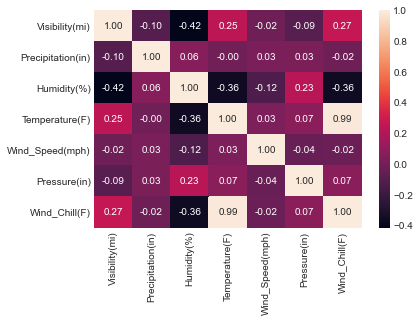

In [16]:
df_temp_precipitations = df.dropna(subset = ['Precipitation(in)'])

df_temp_precipitations.select_dtypes(include='float')
df_temp_precipitations = df_temp_precipitations[['Visibility(mi)', "Precipitation(in)", 
                   'Humidity(%)', 'Temperature(F)', 'Wind_Speed(mph)', 
                                                 'Pressure(in)', "Wind_Chill(F)"]]

sns.heatmap(df_temp_precipitations.corr(), annot = True, fmt = '.2f')

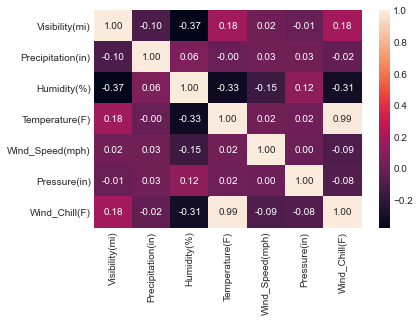

In [17]:
df_only_float = df[['Visibility(mi)', "Precipitation(in)", 
                   'Humidity(%)', 'Temperature(F)', 'Wind_Speed(mph)', 
                    'Pressure(in)', "Wind_Chill(F)"]]
sns.heatmap(df_only_float.corr(), annot = True, fmt = '.2f');

In [18]:
message = """As we can see in the pictures above, the correlations for precipitations are the same for both heat maps. 
However, correlations of other features may be spoiled because of the precipitations nan drop. 
Therefore, we should always use the full data (including nan values). The correlation matrix will 
automatically handle this values, and at the same time, we won't lose valuable records among other features."""

print(message)

As we can see in the pictures above, the correlations for precipitations are the same for both heat maps. 
However, correlations of other features may be spoiled because of the precipitations nan drop. 
Therefore, we should always use the full data (including nan values). The correlation matrix will 
automatically handle this values, and at the same time, we won't lose valuable records among other features.


####  As to be observed in the picture above, there is a very strong correlation between temperature and wind chill (99%). We don't need to worry about the missing values of this columns though. The wind chill column will be dropped

In [19]:
df.drop(axis = 1, columns = "Wind_Chill(F)", inplace = True)

#### No siginificant correlations for precipitations have been found! Let's take a look at the associated weather conditions. At first only for the null values

In [20]:
df.loc[df["Precipitation(in)"].isnull()].Weather_Condition.value_counts().head()

Clear               803332
Overcast            327980
Mostly Cloudy       299495
Partly Cloudy       213173
Scattered Clouds    200021
Name: Weather_Condition, dtype: int64

#### According to the official definition weather "fair" or "clear" is associated with no precipitations 

In [21]:
df.loc[(df.Weather_Condition == "Fair") | (df.Weather_Condition == "Clear")
       , "Precipitation(in)"] = 0.0

#### However, we are still missing around 30% of records

In [22]:
show_incomplete_data(df, .85)

Precipitation(in)    0.711171
dtype: float64

#### Let's see the most common weather conditions associated with precipitations, their lack, and their null values

In [23]:
df.loc[df["Precipitation(in)"] > 0].Weather_Condition.value_counts().head()

Light Rain    124652
Rain           37757
Overcast       20795
Light Snow     17302
Cloudy         16512
Name: Weather_Condition, dtype: int64

In [24]:
df.loc[df["Precipitation(in)"] == 0].Weather_Condition.value_counts().head()

Fair             900872
Clear            808180
Cloudy           297839
Mostly Cloudy    259423
Partly Cloudy    181848
Name: Weather_Condition, dtype: int64

In [25]:
df.loc[df["Precipitation(in)"].isnull()].Weather_Condition.value_counts().head()

Overcast            327980
Mostly Cloudy       299495
Partly Cloudy       213173
Scattered Clouds    200021
Haze                 27329
Name: Weather_Condition, dtype: int64

#### One can clearly see that nan values are associated mainly with questionable weather conditions in terms of possible precipitations (overcast, mostly cloudy, partly cloudy). Let's see the precipiation values for these weather conditions, but provided that the records for precipitations are given. Mayby it will be possible to fill the nan values with the mode, the mean or the median

In [26]:
df_precip_given = df.loc[df["Precipitation(in)"] > 0]

In [27]:
def show_distribution(data_frame, feature, ass_feature, value_ass_feature, distr_start = 0, 
                     distr_end = 1, distr_step = 0.1, histogram_step = 0.01):
    
    data_frame = data_frame.loc[data_frame[ass_feature] == value_ass_feature]
    distribution = data_frame[feature].describe(percentiles = np.arange(distr_start, distr_end, distr_step))
    
    bins = np.arange(0, distribution[-2], histogram_step)
    
    print(distribution)
    return plt.hist(data_frame[feature], bins)

count    20795.000000
mean         0.141088
std          1.000529
min          0.010000
0%           0.010000
10%          0.010000
20%          0.010000
30%          0.010000
40%          0.010000
50%          0.020000
60%          0.020000
70%          0.030000
80%          0.050000
90%          0.090000
max         10.800000
Name: Precipitation(in), dtype: float64


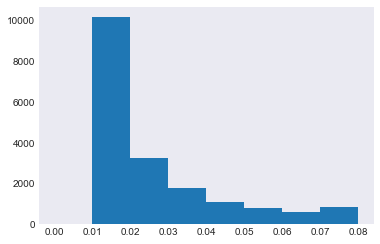

In [28]:
show_distribution(df_precip_given, "Precipitation(in)", "Weather_Condition", "Overcast");

count    12825.000000
mean         0.074608
std          0.460936
min          0.010000
0%           0.010000
10%          0.010000
20%          0.010000
30%          0.010000
40%          0.010000
50%          0.020000
60%          0.030000
70%          0.040000
80%          0.070000
90%          0.130000
max         10.040000
Name: Precipitation(in), dtype: float64


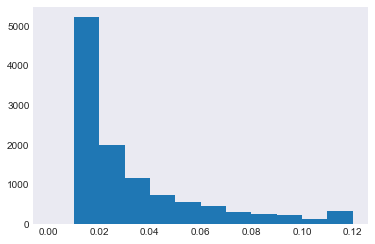

In [29]:
show_distribution(df_precip_given, "Precipitation(in)", "Weather_Condition", "Mostly Cloudy");

count    2394.000000
mean        0.154227
std         0.979246
min         0.010000
0%          0.010000
10%         0.010000
20%         0.010000
30%         0.010000
40%         0.010000
50%         0.020000
60%         0.030000
70%         0.040000
80%         0.070000
90%         0.140000
max        10.020000
Name: Precipitation(in), dtype: float64


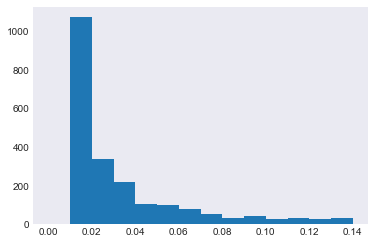

In [30]:
show_distribution(df_precip_given, "Precipitation(in)", "Weather_Condition", "Partly Cloudy");

count    1762.000000
mean        0.116039
std         0.752107
min         0.010000
0%          0.010000
10%         0.010000
20%         0.010000
30%         0.010000
40%         0.020000
50%         0.020000
60%         0.030000
70%         0.050000
80%         0.080000
90%         0.140000
max         9.990000
Name: Precipitation(in), dtype: float64


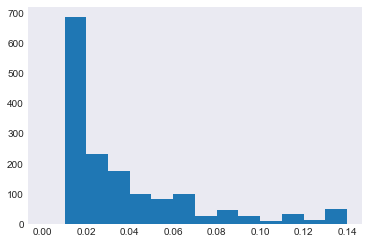

In [31]:
show_distribution(df_precip_given, "Precipitation(in)", "Weather_Condition", "Scattered Clouds");

#### The histograms presented above give us two clues:
- It is not justified to fill the nan values with mode, median or mean. One can neither observe high mode domination nor normal distribution. 
- The precipitation values in case of overcast, mostly cloudy, partly cloudy and scattered clouds conditions are very small - indeed it is possible that the precipitation amount was so small that it couldnt be defined if it was measurable or not.

#### 85% of the nan values are given under the weather conditions stated before (please compare with the cell below)

In [32]:
len(df.loc[df["Precipitation(in)"].isnull()].loc[df.Weather_Condition.isin(["Scattered Clouds",
                                                                      "Partly Cloudy",
                                                                      "Mostly Cloudy",
                                                                      "Overcast" ])]) / \
len(df.loc[df["Precipitation(in)"].isnull()])

0.851276912505726

#### This drives me to conclusion that the categorical state of these precipitations is "questionable".

#### The idea to deal with the remaining nan values (still 30% of all records) is to change the variable characteristics into categorical one. However, this is just an idea. Since the data set is huge I find it justified to try two approaches:
- simple drop of nan values
- using categorical precipitations (thus all the values would be given)


**Division the precipitations into categories**

In [33]:
df.loc[df["Precipitation(in)"] > 0]["Precipitation(in)"].describe(percentiles = np.arange(0,1,0.05))

count    287715.000000
mean          0.087478
std           0.370236
min           0.010000
0%            0.010000
5%            0.010000
10%           0.010000
15%           0.010000
20%           0.010000
25%           0.010000
30%           0.020000
35%           0.020000
40%           0.020000
45%           0.030000
50%           0.030000
55%           0.040000
60%           0.050000
65%           0.060000
70%           0.070000
75%           0.080000
80%           0.100000
85%           0.130000
90%           0.180000
95%           0.280000
max          25.000000
Name: Precipitation(in), dtype: float64

**Values 0 will be `no precipitations`**

**Null values will be `questionable precipitations`**

**Values 0,01 will be ` very small precipitations` (first quartile of precipitations)**

**Values 0,02 and 0,03 will be `small precipitations` (second quartile of precipitations)**

**Values 0,04 and 0,08 will be `moderate precipitations` (third quartile of precipitations)**

**Values above 0,08 will be `high precipitations` (fourth quartile of precipitations)**

### Change precipitation into categories

In [34]:
df["Precipitation_Category"] = np.NaN

In [35]:
def change_into_category(data_frame, column, name, cat_col,
                         compared_value_equal = None, compared_value_bigger = None, 
                         compared_value_smaller = None, compared_value_bigger_equal = None, 
                         compared_value_smaller_equal = None):
    
    
    """ One sided conditions """ """Two sided conditions""" """Equality condition"""
    
    if compared_value_smaller is not None:
        data_frame.loc[df[column] > compared_value_smaller, cat_col] = name
        


    elif compared_value_bigger is not None:
        data_frame.loc[df[column] < compared_value_bigger, cat_col] = name
        
   

    elif compared_value_smaller_equal is not None:
        data_frame.loc[df[column] >= compared_value_smaller_equal, cat_col] = name
        


    elif compared_value_bigger_equal is not None:
        data_frame.loc[df[column] <= compared_value_bigger_equal, cat_col] = name
        

    
    
    
    elif compared_value_smaller is not None and compared_value_bigger is not None:
        data_frame.loc[(df[column] > compared_value_smaller) & \
        (df[column] < compared_value_bigger)         , cat_col] = name
        
        #print(data_frame.loc[(df[column] > compared_value_smaller) & \
        #(df[column] < compared_value_bigger)].head())

             
    elif compared_value_smaller is not None and compared_value_bigger_equal is not None:
        data_frame.loc[(df[column] > compared_value_smaller) & \
        (df[column] <= compared_value_bigger_equal)   , cat_col] = name
       
        
        print(data_frame.loc[(df[column] > compared_value_smaller) & \
        (df[column] <= compared_value_bigger_equal)   , cat_col].head())

    
                                     
    elif compared_value_smaller_equal is not None and compared_value_bigger is not None:
        data_frame.loc[(df[column] >= compared_value_smaller_equal) & \
        (df[column] < compared_value_bigger)          , cat_col] = name
        

        print(data_frame.loc[(df[column] >= compared_value_smaller_equal) & \
        (df[column] < compared_value_bigger)   , cat_col].head())
        
        
        

    elif compared_value_smaller_equal is not None and compared_value_bigger_equal is not None:
        data_frame.loc[(df[column] >= compared_value_smaller_equal) & \
        (df[column] <= compared_value_bigger_equal)   , cat_col] = name 
        
        
        print(data_frame.loc[(df[column] >= compared_value_smaller_equal) & \
        (df[column] <= compared_value_bigger_equal)   , cat_col].head())
        
        
        


    

    elif compared_value_equal is not None:    
        data_frame.loc[df[column] == compared_value_equal, cat_col] = name
    
    return data_frame
 
    
    

In [36]:
change_into_category(df,"Precipitation(in)", "No_Precipitation", "Precipitation_Category", 0);                            


#print(df.Precipitation_Category.value_counts())

change_into_category(df,"Precipitation(in)", "Very_small", "Precipitation_Category",
                     compared_value_smaller = 0,
                     compared_value_bigger_equal = 0.01);
                          
#print(df.Precipitation_Category.value_counts())    
change_into_category(df,"Precipitation(in)", "Small", "Precipitation_Category",
                     compared_value_smaller_equal = 0.02,
                     compared_value_bigger_equal = 0.03);
                               
    
#print(df.Precipitation_Category.value_counts())    
change_into_category(df,"Precipitation(in)", "Moderate", "Precipitation_Category",
                     compared_value_smaller_equal = 0.04,
                     compared_value_bigger_equal = 0.08);
#print(df.Precipitation_Category.value_counts())
change_into_category(df,"Precipitation(in)", "High", "Precipitation_Category",
                     compared_value_smaller = 0.08);
                     
                               

In [37]:
df.Precipitation_Category.fillna("Questionable_Precipitation", inplace = True)

In [38]:
df.Precipitation_Category.value_counts()

No_Precipitation              2722345
Questionable_Precipitation    1222480
Very_small                      80399
High                            70545
Moderate                        69008
Small                           67763
Name: Precipitation_Category, dtype: int64

### Providing final data frames for further polishing

In [39]:
df_ppt_num = df.drop(axis =  1, columns = ["Precipitation_Category"])
df_ppt_num.dropna(inplace = True)
df_ppt_num.reset_index(inplace = True)
df_ppt_num.drop(axis = 1, columns = ["index"], inplace = True)

In [40]:
df_ppt_cat = df.drop(axis = 1, columns = ["Precipitation(in)"])

df_ppt_cat.dropna(inplace = True)
df_ppt_cat.reset_index(inplace = True)

df_ppt_cat.drop(axis = 1, columns = "index", inplace = True)

# 3 Polishing the data before further analysis

### Dropping columns which are not relevant for any of the posed questions

In [41]:
not_relevant_for_any_of_the_posed_questions = ["Source", "Description", "Zipcode", "Timezone", "Airport_Code", 
               "Weather_Timestamp"]

In [42]:
df_ppt_num.drop(axis = 1, columns = not_relevant_for_any_of_the_posed_questions, inplace = True)
df_ppt_cat.drop(axis = 1, columns = not_relevant_for_any_of_the_posed_questions, inplace = True)

### Providing underscored column names and changing the data types

In [43]:
def change_name_to_underscored(column_name):
    return column_name.replace("(", "_").replace(")", "").replace(" " ,"_")

In [44]:
for column in df_ppt_num:
    df_ppt_num.rename(columns = {column: change_name_to_underscored(column)}, inplace = True)
    
for column in df_ppt_cat:
    df_ppt_cat.rename(columns = {column: change_name_to_underscored(column)}, inplace = True)    

### Providing the datetime types for relevant columns

In [45]:
df_ppt_num.Start_Time = pd.to_datetime(df_ppt_num.Start_Time)
df_ppt_num.End_Time = pd.to_datetime(df_ppt_num.End_Time)

In [46]:
df_ppt_cat.Start_Time = pd.to_datetime(df_ppt_cat.Start_Time)
df_ppt_cat.End_Time = pd.to_datetime(df_ppt_cat.End_Time)

### Changing bools into intigers

In [47]:
for column in df_ppt_num.select_dtypes(bool):
    df_ppt_num[column] = df_ppt_num[column].astype(int)
    
for column in df_ppt_cat.select_dtypes(bool):
    df_ppt_cat[column] = df_ppt_cat[column].astype(int)

### Changing the names of twilight columns into more descrpitive ones

In [48]:
df_ppt_num.rename(columns = {"Sunrise_Sunset": "After_Sunset", 
                     "Civil_Twilight": "After_Civil_Twilight",
                     "Nautical_Twilight" : "After_Nautical_Twilight",
                     "Astronomical_Twilight": "After_Astronomical_Twilight"}, inplace = True)

In [49]:
df_ppt_cat.rename(columns = {"Sunrise_Sunset": "After_Sunset", 
                     "Civil_Twilight": "After_Civil_Twilight",
                     "Nautical_Twilight" : "After_Nautical_Twilight",
                     "Astronomical_Twilight": "After_Astronomical_Twilight"}, inplace = True)

In [50]:
df_ppt_num[["After_Sunset", "After_Civil_Twilight", "After_Nautical_Twilight", "After_Astronomical_Twilight"]]\
= df_ppt_num[["After_Sunset", 
    "After_Civil_Twilight", 
    "After_Nautical_Twilight", 
    "After_Astronomical_Twilight"]].replace(["Night","Day"],  [1,0])


df_ppt_cat[["After_Sunset", "After_Civil_Twilight", "After_Nautical_Twilight", "After_Astronomical_Twilight"]]\
= df_ppt_cat[["After_Sunset", 
    "After_Civil_Twilight", 
    "After_Nautical_Twilight", 
    "After_Astronomical_Twilight"]].replace(["Night","Day"],  [1,0])

### Getting dummies for categorical variables

In [51]:
def create_dummy_df(df, cat_cols, dummy_na):
    '''
    INPUT:
    df - pandas dataframe with categorical variables you want to dummy
    cat_cols - list of strings that are associated with names of the categorical columns
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    
    OUTPUT:
    df - a new dataframe that has the following characteristics:
            1. contains all columns that were not specified as categorical
            2. removes all the original columns in cat_cols
            3. dummy columns for each of the categorical columns in cat_cols
            4. if dummy_na is True - it also contains dummy columns for the NaN values
            5. Use a prefix of the column name with an underscore (_) for separating 
    '''
        
    for col in  cat_cols:
        try:
            # for each cat add dummy var, drop original column
            df = pd.concat([df.drop(col, axis=1), 
                 pd.get_dummies(df[col], prefix=col, prefix_sep='_', 
                 drop_first=True, dummy_na=dummy_na)], axis=1)
        except:
            continue
    return df

In [52]:
df_ppt_num = create_dummy_df(df_ppt_num, 
        ["Side", "Weather_Condition", "Wind_Direction"], dummy_na = False)

df_ppt_cat = create_dummy_df(df_ppt_cat, 
        ["Precipitation_Category", "Side", "Weather_Condition", "Wind_Direction"], dummy_na = False)

In [53]:
for column in df_ppt_num:
    df_ppt_num.rename(columns = {column: change_name_to_underscored(column)}, inplace = True) 
    
for column in df_ppt_cat:
    df_ppt_cat.rename(columns = {column: change_name_to_underscored(column)}, inplace = True) 

### Changing Lat and Lng to coordinates column (4th decimal place means around 10-20m accuracy)

In [54]:
df_ppt_num["Coordinates_10m"] = list(zip(df_ppt_num.Start_Lat.values.round(4), 
                                     df_ppt_num.Start_Lng.values.round(4) ))

df_ppt_cat["Coordinates_10m"] = list(zip(df_ppt_cat.Start_Lat.values.round(4), 
                                     df_ppt_cat.Start_Lng.values.round(4) ))

df_ppt_num["Coordinates_100m"] = list(zip(df_ppt_num.Start_Lat.values.round(3), 
                                     df_ppt_num.Start_Lng.values.round(3) ))

df_ppt_cat["Coordinates_100m"] = list(zip(df_ppt_cat.Start_Lat.values.round(3), 
                                     df_ppt_cat.Start_Lng.values.round(3) ))

### Changing Start_Time and End_Time into minutes (intiger), since a minute will be the highest accuracy level of the model predictions 

In [55]:
df_ppt_num["Duration_minutes"] = (df_ppt_num.End_Time.dt.round('min') 
                                  - df_ppt_num.Start_Time.dt.round("min"))

df_ppt_num.drop(axis = 1, columns = ["End_Time"], inplace = True)
df_ppt_num.Duration_minutes = (df_ppt_num.Duration_minutes.dt.seconds) / 60




df_ppt_cat["Duration_minutes"] = (df_ppt_cat.End_Time.dt.round('min') 
                                  - df_ppt_cat.Start_Time.dt.round("min"))

df_ppt_cat.drop(axis = 1, columns = ["End_Time"], inplace = True)
df_ppt_cat.Duration_minutes = (df_ppt_cat.Duration_minutes.dt.seconds) / 60

In [56]:
df_ppt_cat.groupby("Severity")['Duration_minutes'].mean()

Severity
1     40.035460
2    109.903272
3     70.232078
4    197.439938
Name: Duration_minutes, dtype: float64

# 4 Analysis via Descriptive Statistics

In [57]:
continental_USA = gpd.read_file(gplt.datasets.get_path('contiguous_usa'))

In [58]:
sample_sev1 = df_ppt_cat.sample(20000)[["Severity","Start_Lng", "Start_Lat"]].query("Severity==1")
sample_sev2 = df_ppt_cat.sample(20000)[["Severity","Start_Lng", "Start_Lat"]].query("Severity==2")
sample_sev3 = df_ppt_cat.sample(20000)[["Severity","Start_Lng", "Start_Lat"]].query("Severity==3")
sample_sev4 = df_ppt_cat.sample(20000)[["Severity","Start_Lng", "Start_Lat"]].query("Severity==4")

In [59]:
def make_geodataframe(dataframe):
    
    geo_data_frame = gpd.GeoDataFrame(dataframe, 
                              geometry=gpd.points_from_xy(dataframe.Start_Lng, 
                              dataframe.Start_Lat))
    
    return geo_data_frame

In [60]:
gdf_sample_sev1 = make_geodataframe(sample_sev1)
gdf_sample_sev2 = make_geodataframe(sample_sev2)
gdf_sample_sev3 = make_geodataframe(sample_sev3)
gdf_sample_sev4 = make_geodataframe(sample_sev4)

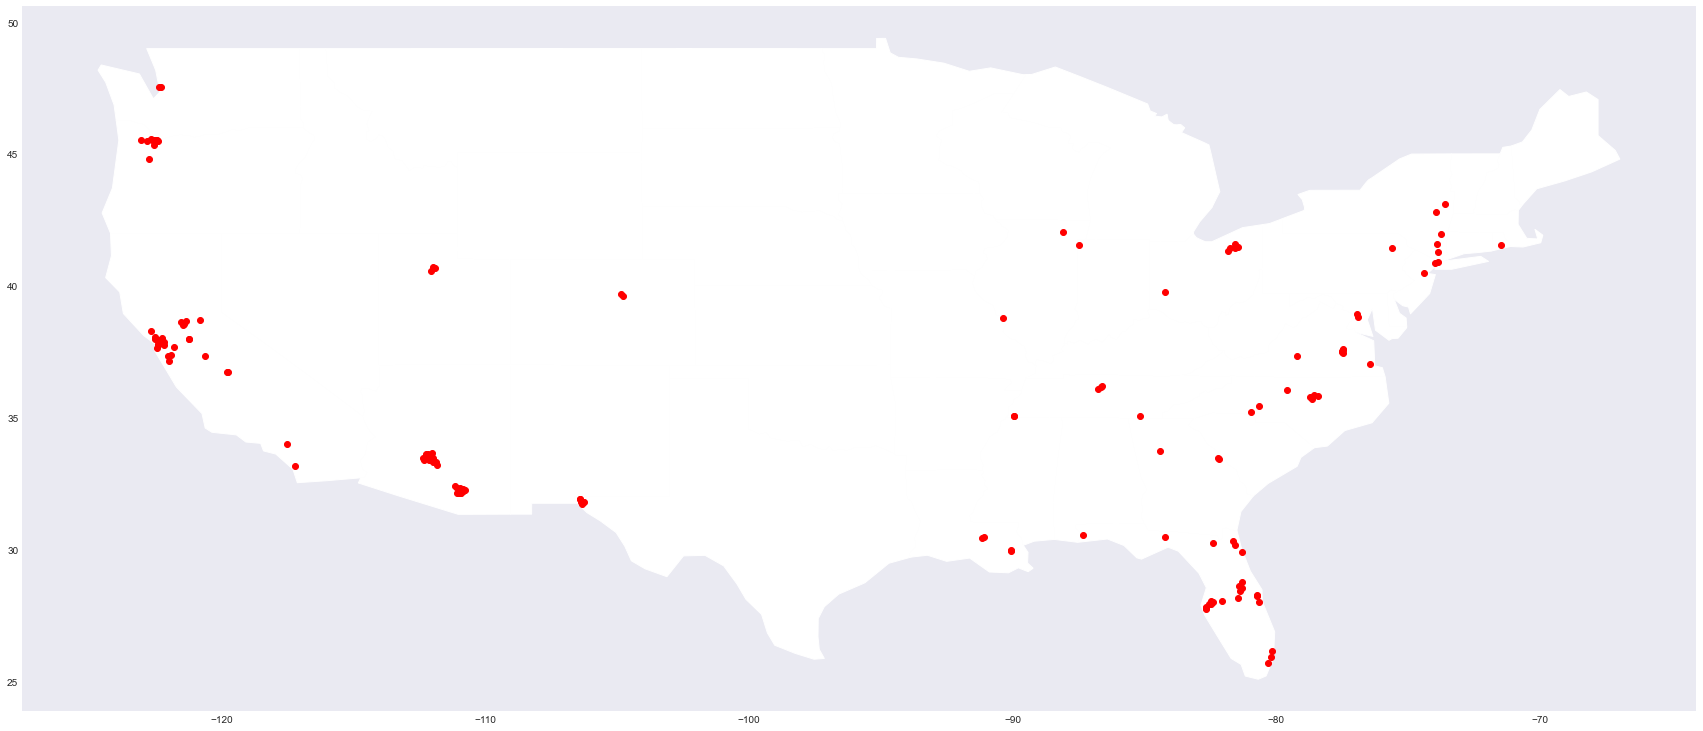

In [61]:
rcParams['figure.figsize'] = 30, 30
#figure(figsize = (1,1), dpi = 3000)
ax = continental_USA.plot(
    color='white', edgecolor='white')
# We can now plot our ``GeoDataFrame``.


gdf_sample_sev1.plot(ax=ax, color='red')

plt.show()

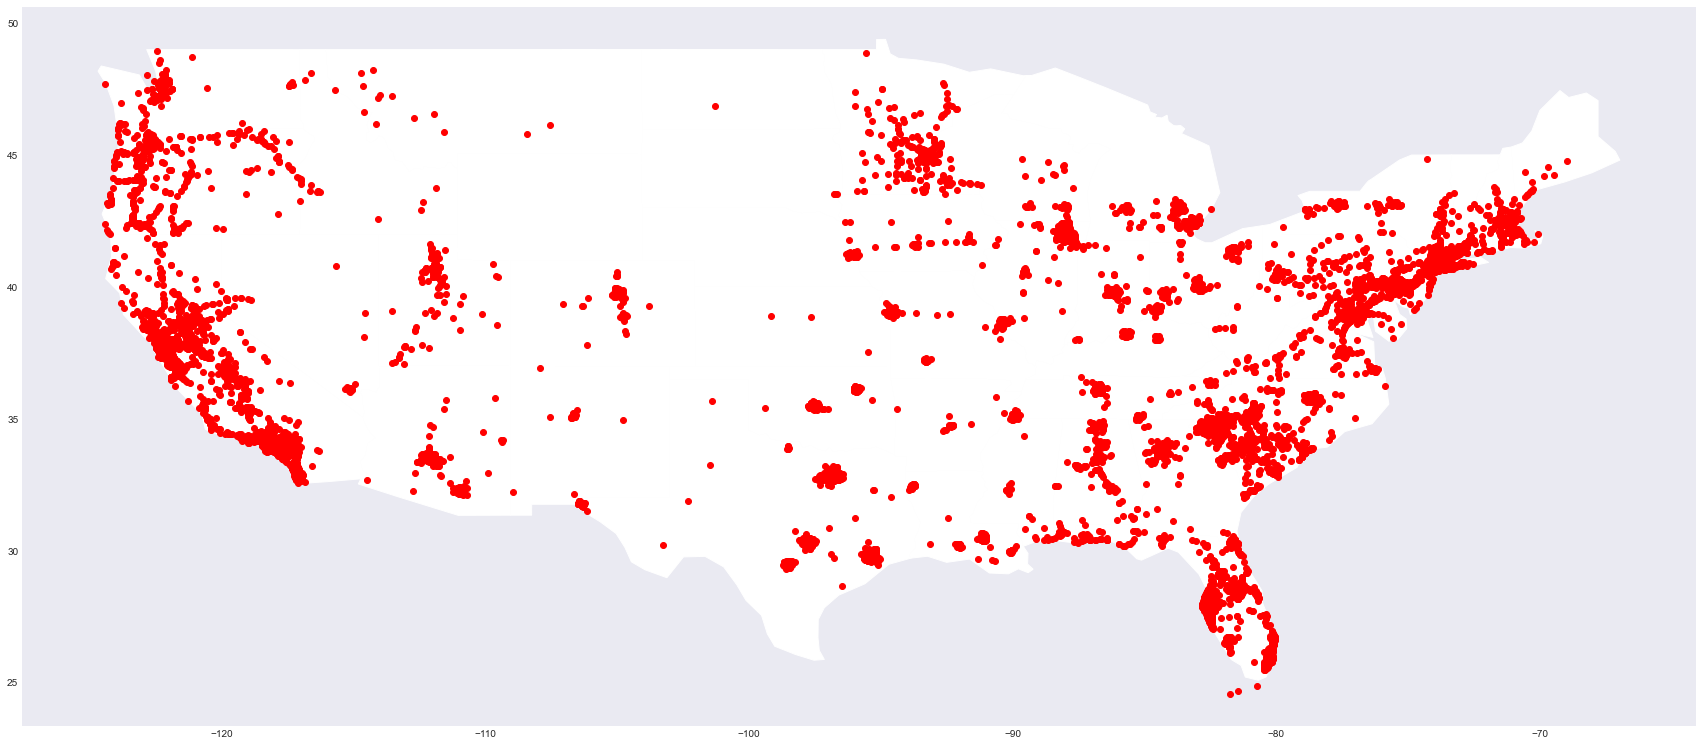

In [62]:
rcParams['figure.figsize'] = 30, 30
#figure(figsize = (1,1), dpi = 3000)
ax = continental_USA.plot(
    color='white', edgecolor='white')
# We can now plot our ``GeoDataFrame``.


gdf_sample_sev2.plot(ax=ax, color='red')

plt.show()

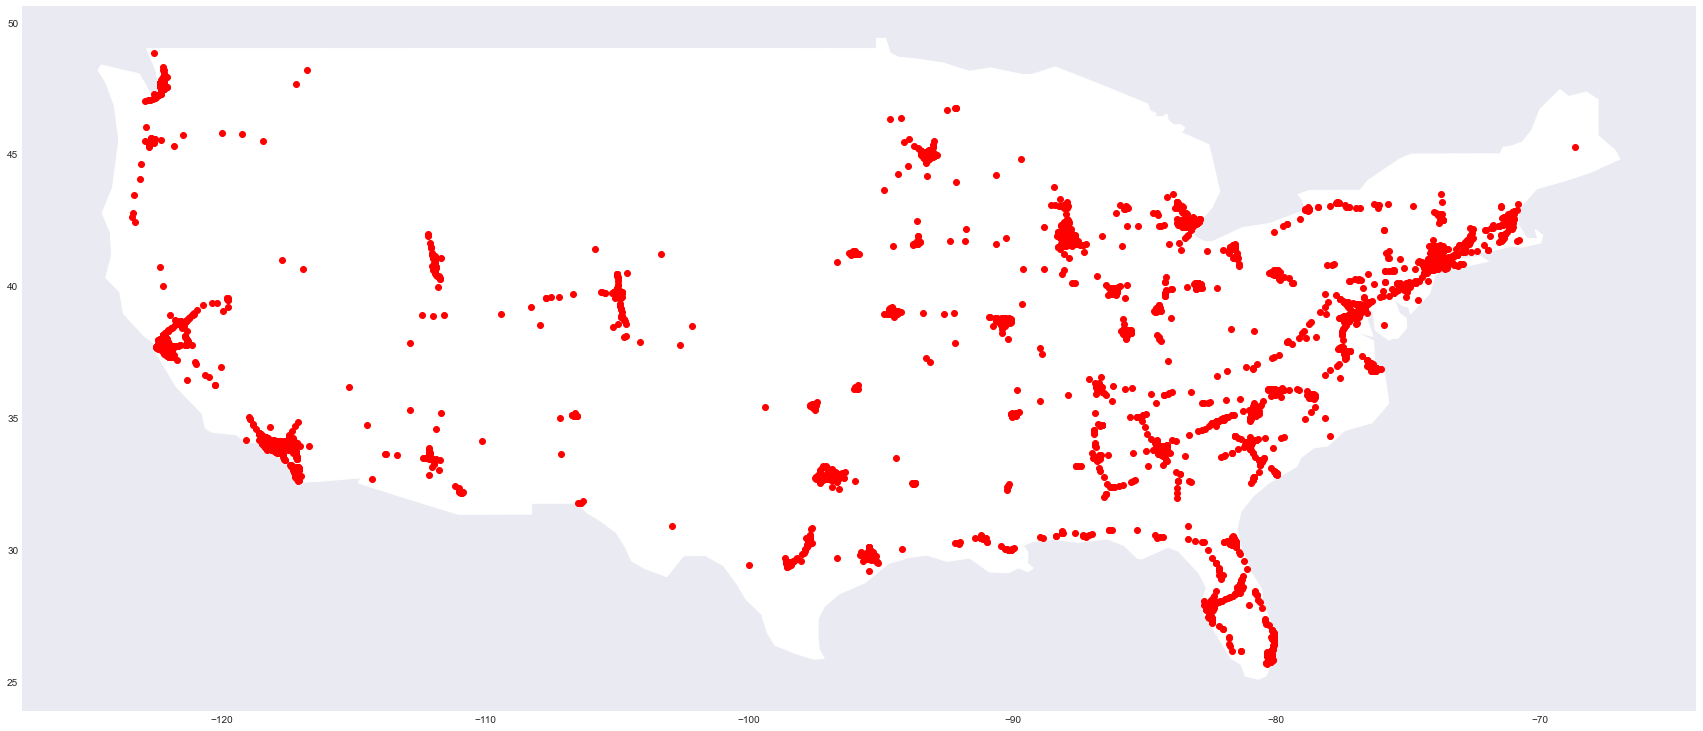

In [63]:
rcParams['figure.figsize'] = 30, 30
#figure(figsize = (1,1), dpi = 3000)
ax = continental_USA.plot(
    color='white', edgecolor='white')
# We can now plot our ``GeoDataFrame``.


gdf_sample_sev3.plot(ax=ax, color='red')

plt.show()

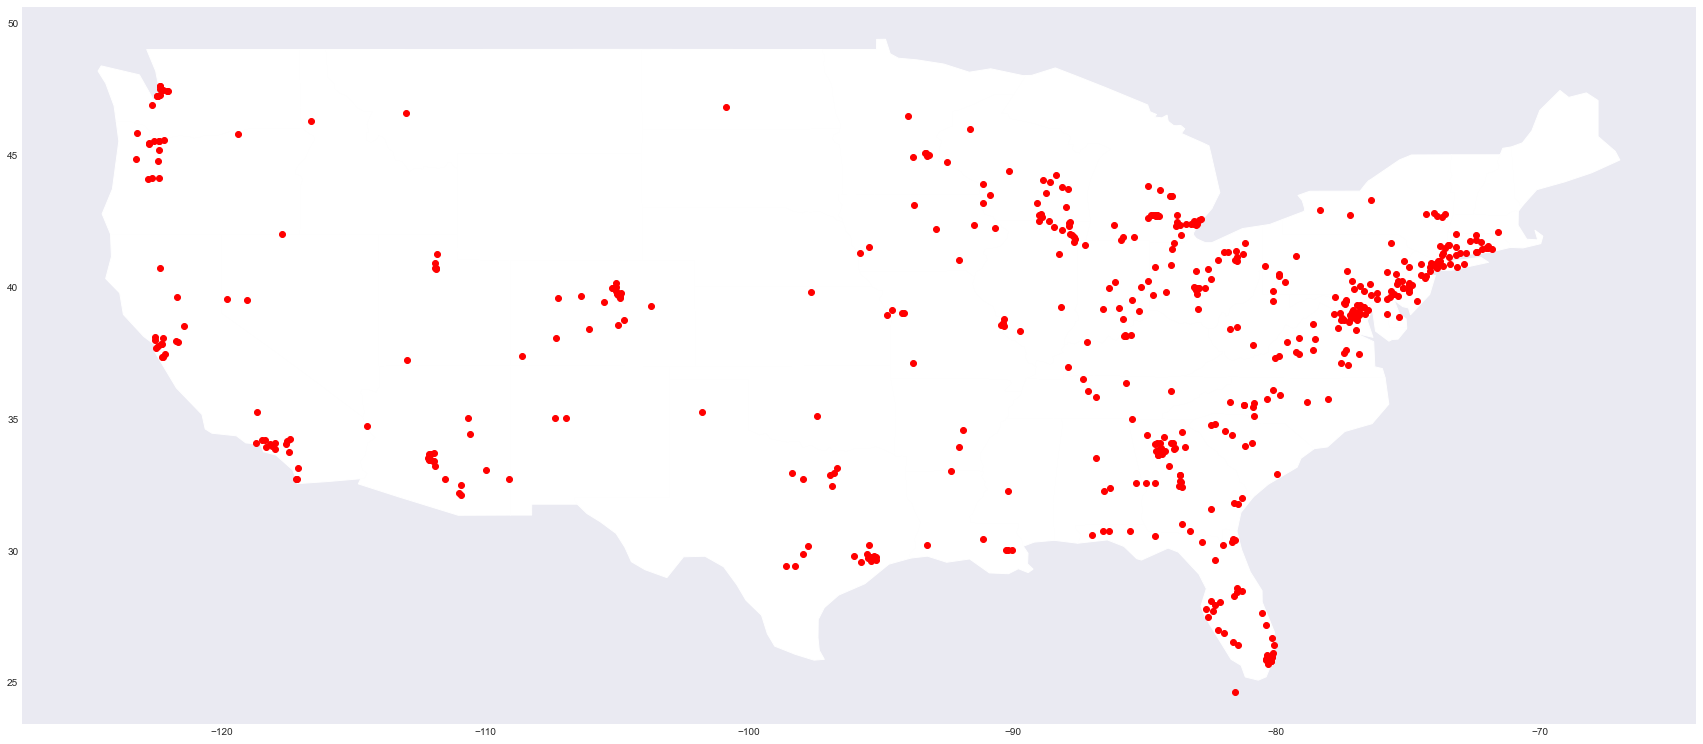

In [64]:
rcParams['figure.figsize'] = 30, 30
#figure(figsize = (1,1), dpi = 3000)
ax = continental_USA.plot(
    color='white', edgecolor='white')
# We can now plot our ``GeoDataFrame``.


gdf_sample_sev4.plot(ax=ax, color='red')

plt.show()

In [65]:
df_ppt_num["is_HotSpot_10m"] = 0
df_ppt_cat["is_HotSpot_10m"] = 0
df_ppt_num["is_HotSpot_100m"] = 0
df_ppt_cat["is_HotSpot_100m"] = 0

#### Threshold for hot spot - 40 accidents

In [66]:
hot_spots_num = df_ppt_num.Coordinates_10m.value_counts()[
    df_ppt_num.Coordinates_10m.value_counts() >= 40]

df_ppt_num.loc[df_ppt_num.Coordinates_10m.isin(list(hot_spots_num.index)), "is_HotSpot_10m"] = 1
#df_hot_spots = df.query('Coordinates in @hot_spots.index')


hot_spots_cat = df_ppt_cat.Coordinates_10m.value_counts()[
    df_ppt_cat.Coordinates_10m.value_counts() >= 40]

df_ppt_cat.loc[df_ppt_cat.Coordinates_10m.isin(list(hot_spots_cat.index)), "is_HotSpot_10m"] = 1

In [67]:
hot_spots_num = df_ppt_num.Coordinates_100m.value_counts()[
    df_ppt_num.Coordinates_100m.value_counts() >= 40]

df_ppt_num.loc[df_ppt_num.Coordinates_100m.isin(list(hot_spots_num.index)), "is_HotSpot_100m"] = 1
#df_hot_spots = df.query('Coordinates in @hot_spots.index')


hot_spots_cat = df_ppt_cat.Coordinates_100m.value_counts()[
    df_ppt_cat.Coordinates_100m.value_counts() >= 40]

df_ppt_cat.loc[df_ppt_cat.Coordinates_100m.isin(list(hot_spots_cat.index)), "is_HotSpot_100m"] = 1

In [68]:
print(df_ppt_cat.is_HotSpot_10m.mean())
print(df_ppt_num.is_HotSpot_10m.mean())

0.1678027638989263
0.11558423805358445


In [69]:
print(df_ppt_cat.is_HotSpot_100m.mean())
print(df_ppt_num.is_HotSpot_100m.mean())

0.30503375980509895
0.23512219631247877


#### The rest of descriptive statistics will be done only on the data frame with categorical precipitations (more records) - the second data frame will be driven back into analysis at the inferential stage

In [70]:
hot_spot100m_only_gps = df_ppt_cat.loc[df_ppt_cat.is_HotSpot_100m ==1][["Start_Lat", "Start_Lng"]]
hot_spot10m_only_gps = df_ppt_cat.loc[df_ppt_cat.is_HotSpot_10m ==1][["Start_Lat", "Start_Lng"]]

In [71]:
gdf_hot100 = gpd.GeoDataFrame(hot_spot100m_only_gps, 
                              geometry=gpd.points_from_xy(hot_spot100m_only_gps.Start_Lng, 
                              hot_spot100m_only_gps.Start_Lat))

In [72]:
gdf_hot10 = gpd.GeoDataFrame(hot_spot10m_only_gps, 
                              geometry=gpd.points_from_xy(hot_spot10m_only_gps.Start_Lng, 
                              hot_spot10m_only_gps.Start_Lat))

In [73]:
continental_USA_cities = gpd.read_file(gplt.datasets.get_path('usa_cities'))
continental_USA_cities = continental_USA_cities.query('STATE not in ["AK", "HI", "PR"]')
continental_USA_cities_more500k = continental_USA_cities.query('POP_2010 > 300000')

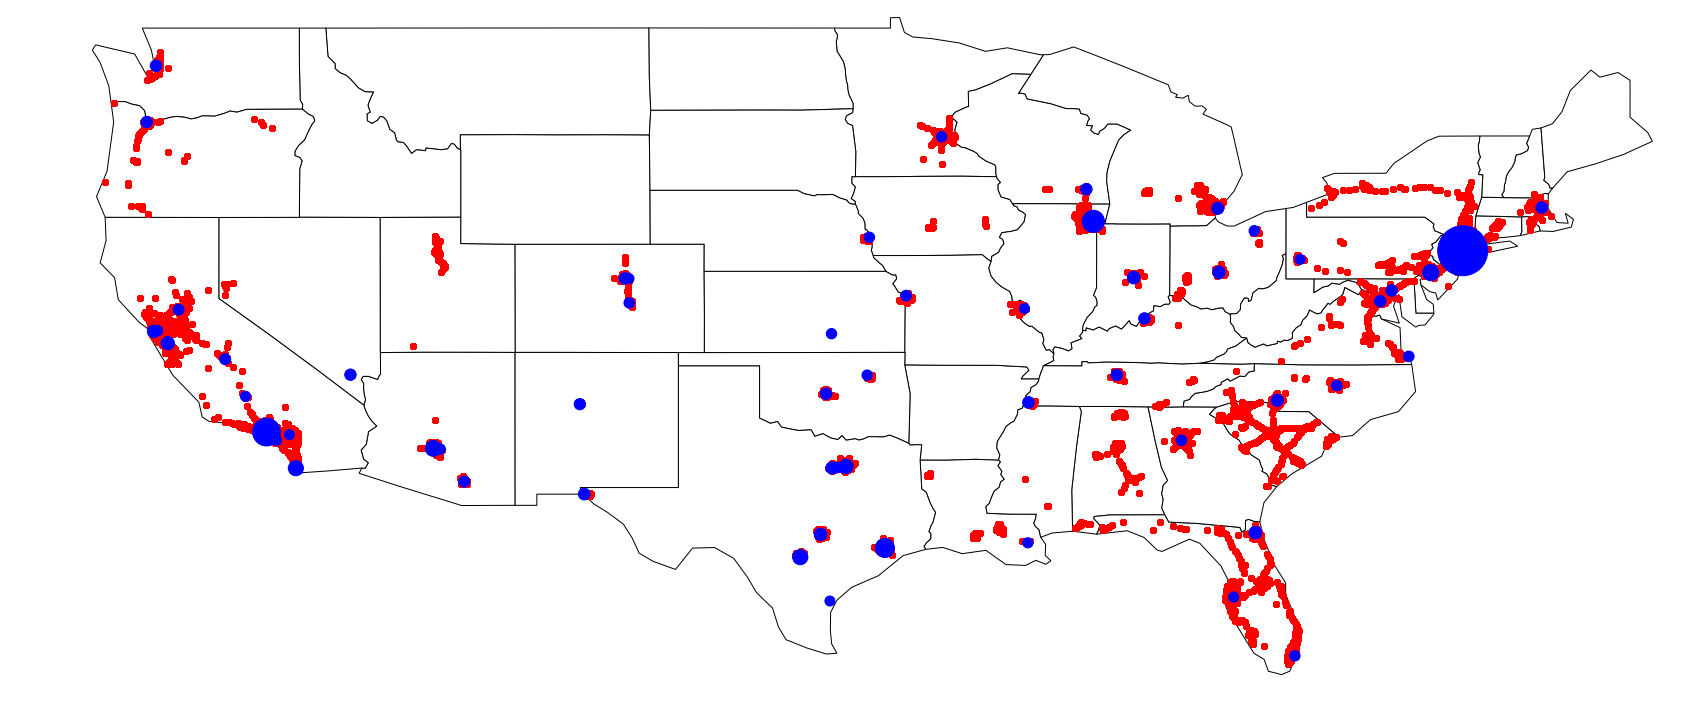

In [74]:
rcParams['figure.figsize'] = 30, 30
#figure(figsize = (1,1), dpi = 3000)
ax = continental_USA.plot(
    color='white', edgecolor='black')
# We can now plot our ``GeoDataFrame``.
gdf_hot100.plot(ax=ax, color='red')
gplt.pointplot(continental_USA_cities_more500k, ax = ax, color = 'blue', scale = "POP_2010", limits=(10, 50))



plt.show()

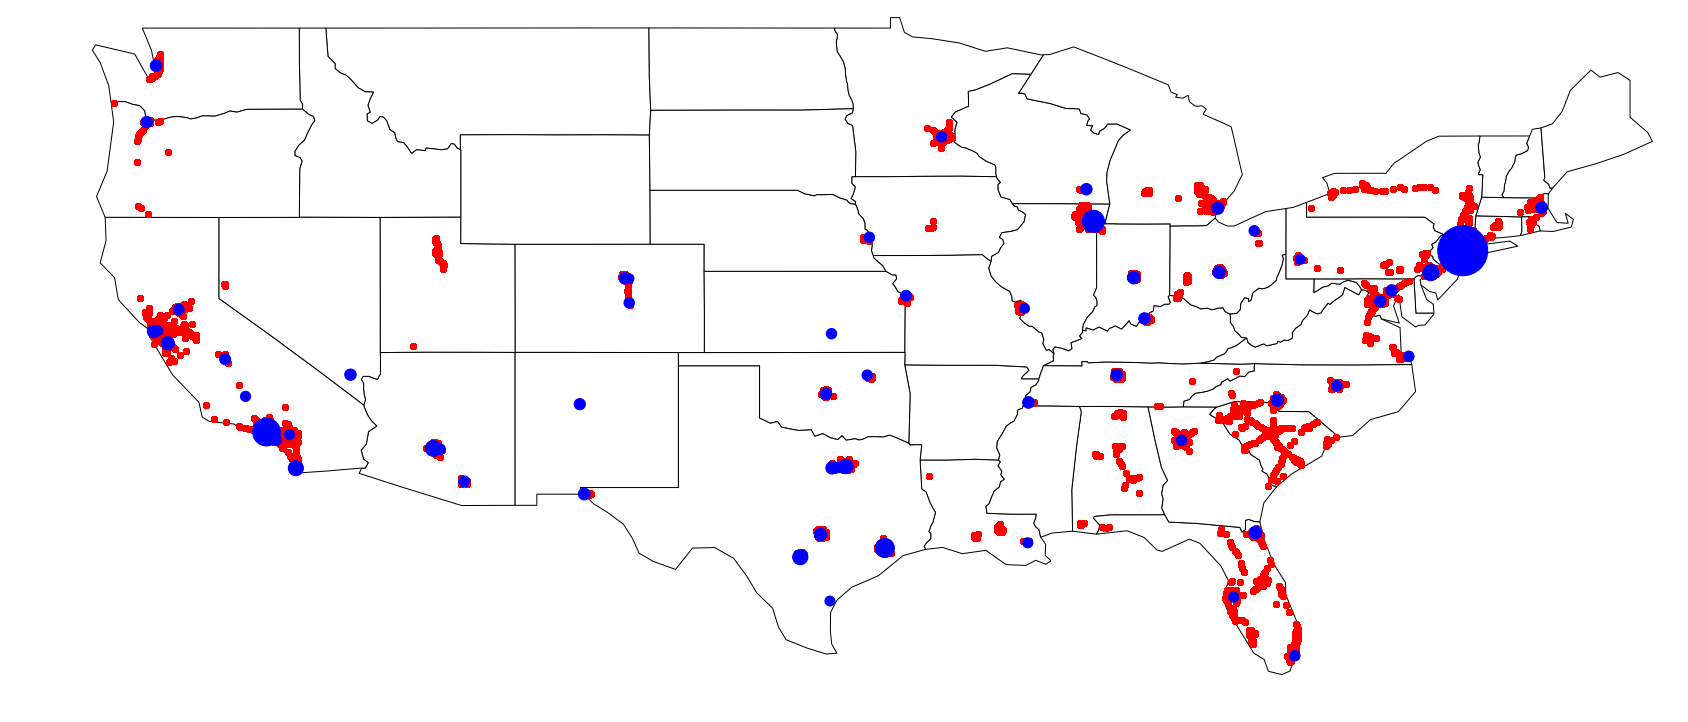

In [75]:
rcParams['figure.figsize'] = 30, 30
#figure(figsize = (1,1), dpi = 3000)
ax = continental_USA.plot(
    color='white', edgecolor='black')
# We can now plot our ``GeoDataFrame``.
gdf_hot10.plot(ax=ax, color='red')
gplt.pointplot(continental_USA_cities_more500k, ax = ax, color = 'blue', scale = "POP_2010", limits=(10, 50))



plt.show()

In [76]:
data_frame_for_depiction = df_ppt_cat.query("(State == 'UT' | State == 'NY'| State == 'SC') & \
                                            is_HotSpot_10m")

In [77]:
gdf_hot10_depict = gpd.GeoDataFrame(data_frame_for_depiction, 
                              geometry=gpd.points_from_xy(data_frame_for_depiction.Start_Lng, 
                              data_frame_for_depiction.Start_Lat))

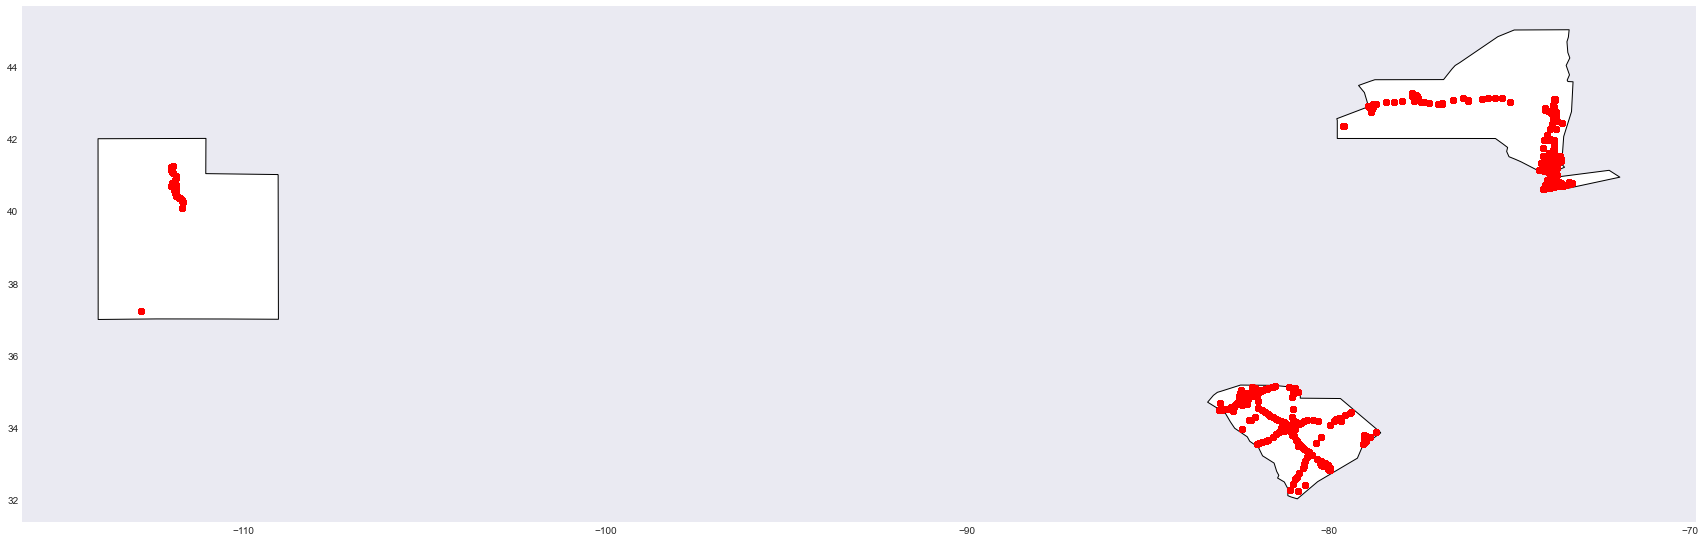

In [78]:
rcParams['figure.figsize'] = 30, 30
#figure(figsize = (1,1), dpi = 3000)
ax = continental_USA.query("state == 'Utah' | state == 'New York'| state == 'South Carolina'").plot(
    color='white', edgecolor='black')
# We can now plot our ``GeoDataFrame``.
gdf_hot10_depict.plot(ax=ax, color='red')




plt.show()

In [79]:
df_hot_spots_10m = df_ppt_cat.query("is_HotSpot_10m == 1")
df_hot_spots_100m = df_ppt_cat.query("is_HotSpot_100m == 1")

In [80]:
print("Hot Spots (accuracy ~10m) - percentual [%] presence of road objects and facilities\
      \n \nRoundabouts       {}\
      \nStop signs        {}\
      \nRailways          {}\
      \nJunctions         {}\
      \nRight of way      {}\
      \nTraffic Signal    {}\
      \nStation           {}\
      \nCrossing          {}\
      \nBump              {}\
      \nAmenity           {}".format(
            round(df_hot_spots_10m.Roundabout.mean()*100, 2), 
            round(df_hot_spots_10m.Stop.mean()*100, 2) ,
            round(df_hot_spots_10m.Railway.mean()*100, 2) ,
            round(df_hot_spots_10m.Junction.mean()*100, 2) ,
            round(df_hot_spots_10m.Give_Way.mean()*100, 2) ,
            round(df_hot_spots_10m.Traffic_Signal.mean()*100, 2) ,
            round(df_hot_spots_10m.Station.mean()*100, 2) ,
            round(df_hot_spots_10m.Crossing.mean()*100, 2) ,
            round(df_hot_spots_10m.Bump.mean()*100, 2),
            round(df_hot_spots_10m.Amenity.mean()*100, 2)))

Hot Spots (accuracy ~10m) - percentual [%] presence of road objects and facilities      
 
Roundabouts       0.0      
Stop signs        0.48      
Railways          0.87      
Junctions         11.18      
Right of way      0.29      
Traffic Signal    19.2      
Station           1.33      
Crossing          6.47      
Bump              0.01      
Amenity           0.4


In [81]:
df_hot_spots_10m_just_weather = df_hot_spots_10m.copy()

In [82]:
for index, column in enumerate(df_hot_spots_10m_just_weather.dtypes):
    if column not in ["uint8", "int64", "float64", "int32"]:
        df_hot_spots_10m_just_weather.drop(df_hot_spots_10m.columns[index], 
                                           axis = 1, inplace = True)

In [83]:
for column in df_hot_spots_10m_just_weather:
    if df_hot_spots_10m_just_weather[column].mean() > 0.05 \
        and df_hot_spots_10m_just_weather[column].mean() < 1:
        print(df_hot_spots_10m_just_weather[column].name)
        print(df_hot_spots_10m_just_weather[column].mean())

TMC
0.8029701540436457
Distance_mi
0.20577599650251394
Crossing
0.06474165596919126
Junction
0.11183889602053915
Traffic_Signal
0.1919624518613607
After_Sunset
0.26111360718870347
After_Civil_Twilight
0.2157028241335045
After_Nautical_Twilight
0.16737163029525032
After_Astronomical_Twilight
0.13051347881899872
Precipitation_Category_No_Precipitation
0.5977069961489089
Precipitation_Category_Questionable_Precipitation
0.3289120667522465
Side_R
0.9265949935815148
Weather_Condition_Clear
0.2034066110397946
Weather_Condition_Cloudy
0.057995827984595634
Weather_Condition_Fair
0.18162227214377408
Weather_Condition_Light_Rain
0.053109756097560974
Weather_Condition_Mostly_Cloudy
0.15762997432605905
Weather_Condition_Overcast
0.09907252888318357
Weather_Condition_Partly_Cloudy
0.11146501925545571
Weather_Condition_Scattered_Clouds
0.06439826700898588
Wind_Direction_SSE
0.050510269576379975
Wind_Direction_SSW
0.05863607188703466
Wind_Direction_SW
0.05765885750962773
Wind_Direction_South
0.057249

In [84]:
print("Hot Spots (accuracy ~10m) - percentual [%] presence of particular weather conditions\
      \n \nAfter_Sunset                                        {}\
      \nPrecipitation_Category_No_Precipitation             {}\
      \nPrecipitation_Category_Questionable_Precipitation   {}\
      \nWeather_Condition_Clear                             {}\
      \nWeather_Condition_Cloudy                            {}\
      \nWeather_Condition_Fair                              {}\
      \nWeather_Condition_Light_Rain                        {}\
      \nWeather_Condition_Mostly_Cloudy                     {}\
      \nWeather_Condition_Overcast                          {}\
      \nWeather_Condition_Partly_Cloudy                     {}\
      \nWeather_Condition_Scattered_Clouds                  {}".format(
            round(df_hot_spots_10m.After_Sunset.mean()*100,2),
            round(df_hot_spots_10m.Precipitation_Category_No_Precipitation.mean()*100, 2), 
            round(df_hot_spots_10m.Precipitation_Category_Questionable_Precipitation.mean()*100, 2) ,
            round(df_hot_spots_10m.Weather_Condition_Clear.mean()*100, 2) ,
            round(df_hot_spots_10m.Weather_Condition_Cloudy.mean()*100, 2) ,
            round(df_hot_spots_10m.Weather_Condition_Fair.mean()*100, 2) ,
            round(df_hot_spots_10m.Weather_Condition_Light_Rain.mean()*100, 2) ,
            round(df_hot_spots_10m.Weather_Condition_Mostly_Cloudy.mean()*100, 2) ,
            round(df_hot_spots_10m.Weather_Condition_Overcast.mean()*100, 2) ,
            round(df_hot_spots_10m.Weather_Condition_Partly_Cloudy.mean()*100, 2),
            round(df_hot_spots_10m.Weather_Condition_Scattered_Clouds.mean()*100, 2)))

Hot Spots (accuracy ~10m) - percentual [%] presence of particular weather conditions      
 
After_Sunset                                        26.11      
Precipitation_Category_No_Precipitation             59.77      
Precipitation_Category_Questionable_Precipitation   32.89      
Weather_Condition_Clear                             20.34      
Weather_Condition_Cloudy                            5.8      
Weather_Condition_Fair                              18.16      
Weather_Condition_Light_Rain                        5.31      
Weather_Condition_Mostly_Cloudy                     15.76      
Weather_Condition_Overcast                          9.91      
Weather_Condition_Partly_Cloudy                     11.15      
Weather_Condition_Scattered_Clouds                  6.44


In [85]:
print("Hot Spots (accuracy ~100m) - percentual [%] presence of road objects and facilities\
      \n \nRoundabouts       {}\
      \nStop signs        {}\
      \nRailways          {}\
      \nJunctions         {}\
      \nRight of way      {}\
      \nTraffic Signal    {}\
      \nStation           {}\
      \nCrossing          {}\
      \nBump              {}\
      \nAmenity           {}".format(
            round(df_hot_spots_100m.Roundabout.mean()*100, 2), 
            round(df_hot_spots_100m.Stop.mean()*100, 2) ,
            round(df_hot_spots_100m.Railway.mean()*100, 2) ,
            round(df_hot_spots_100m.Junction.mean()*100, 2) ,
            round(df_hot_spots_100m.Give_Way.mean()*100, 2) ,
            round(df_hot_spots_100m.Traffic_Signal.mean()*100, 2) ,
            round(df_hot_spots_100m.Station.mean()*100, 2) ,
            round(df_hot_spots_100m.Crossing.mean()*100, 2) ,
            round(df_hot_spots_100m.Bump.mean()*100, 2),
            round(df_hot_spots_100m.Amenity.mean()*100, 2)))

Hot Spots (accuracy ~100m) - percentual [%] presence of road objects and facilities      
 
Roundabouts       0.0      
Stop signs        0.49      
Railways          0.84      
Junctions         12.0      
Right of way      0.34      
Traffic Signal    19.16      
Station           1.32      
Crossing          6.87      
Bump              0.01      
Amenity           0.49


In [86]:
print("Hot Spots (accuracy ~100m) - percentual [%] presence of particular weather conditions\
      \n \nAfter_Sunset                                        {}\
      \nPrecipitation_Category_No_Precipitation             {}\
      \nPrecipitation_Category_Questionable_Precipitation   {}\
      \nWeather_Condition_Clear                             {}\
      \nWeather_Condition_Cloudy                            {}\
      \nWeather_Condition_Fair                              {}\
      \nWeather_Condition_Light_Rain                        {}\
      \nWeather_Condition_Mostly_Cloudy                     {}\
      \nWeather_Condition_Overcast                          {}\
      \nWeather_Condition_Partly_Cloudy                     {}\
      \nWeather_Condition_Scattered_Clouds                  {}".format(
            round(df_hot_spots_100m.After_Sunset.mean()*100,2),
            round(df_hot_spots_100m.Precipitation_Category_No_Precipitation.mean()*100, 2), 
            round(df_hot_spots_100m.Precipitation_Category_Questionable_Precipitation.mean()*100, 2) ,
            round(df_hot_spots_100m.Weather_Condition_Clear.mean()*100, 2) ,
            round(df_hot_spots_100m.Weather_Condition_Cloudy.mean()*100, 2) ,
            round(df_hot_spots_100m.Weather_Condition_Fair.mean()*100, 2) ,
            round(df_hot_spots_100m.Weather_Condition_Light_Rain.mean()*100, 2) ,
            round(df_hot_spots_100m.Weather_Condition_Mostly_Cloudy.mean()*100, 2) ,
            round(df_hot_spots_100m.Weather_Condition_Overcast.mean()*100, 2) ,
            round(df_hot_spots_100m.Weather_Condition_Partly_Cloudy.mean()*100, 2),
            round(df_hot_spots_100m.Weather_Condition_Scattered_Clouds.mean()*100, 2)))

Hot Spots (accuracy ~100m) - percentual [%] presence of particular weather conditions      
 
After_Sunset                                        27.83      
Precipitation_Category_No_Precipitation             63.48      
Precipitation_Category_Questionable_Precipitation   29.23      
Weather_Condition_Clear                             18.39      
Weather_Condition_Cloudy                            6.93      
Weather_Condition_Fair                              21.34      
Weather_Condition_Light_Rain                        5.28      
Weather_Condition_Mostly_Cloudy                     15.29      
Weather_Condition_Overcast                          8.93      
Weather_Condition_Partly_Cloudy                     10.8      
Weather_Condition_Scattered_Clouds                  5.51


# 5 Inferential Statistics - trying to predict the Severity of an Accident using multi layer perceptron classifier

## a. Predictions using data set with precipitations as categorical variable

In [87]:
df_ppt_cat_pred_Sev = df_ppt_cat.drop(axis =1 , 
            columns = ["ID", "State", "Street", "City", "County", 
                       "Coordinates_10m", "Coordinates_100m", "Start_Lat", "Start_Lng"])

In [88]:
variables = df_ppt_cat_pred_Sev.drop(axis = 1, columns = ["Severity", "Duration_minutes"])

#### Providing the values for correlations

In [89]:
correlations = df_ppt_cat_pred_Sev.corr()['Severity']

#### I have decided to use only the variables which have at least 0.05 correlation with regard to severity

In [90]:
correlated_values = correlations.index[(correlations.values >= 0.05) | (correlations.values <= -0.05)]

In [91]:
not_correlated = df_ppt_cat_pred_Sev.drop(list(correlated_values), axis = 1)

In [92]:
df_ppt_cat_pred_Sev_only_correlated = df_ppt_cat_pred_Sev.drop(list(not_correlated.columns), axis = 1)

<AxesSubplot:>

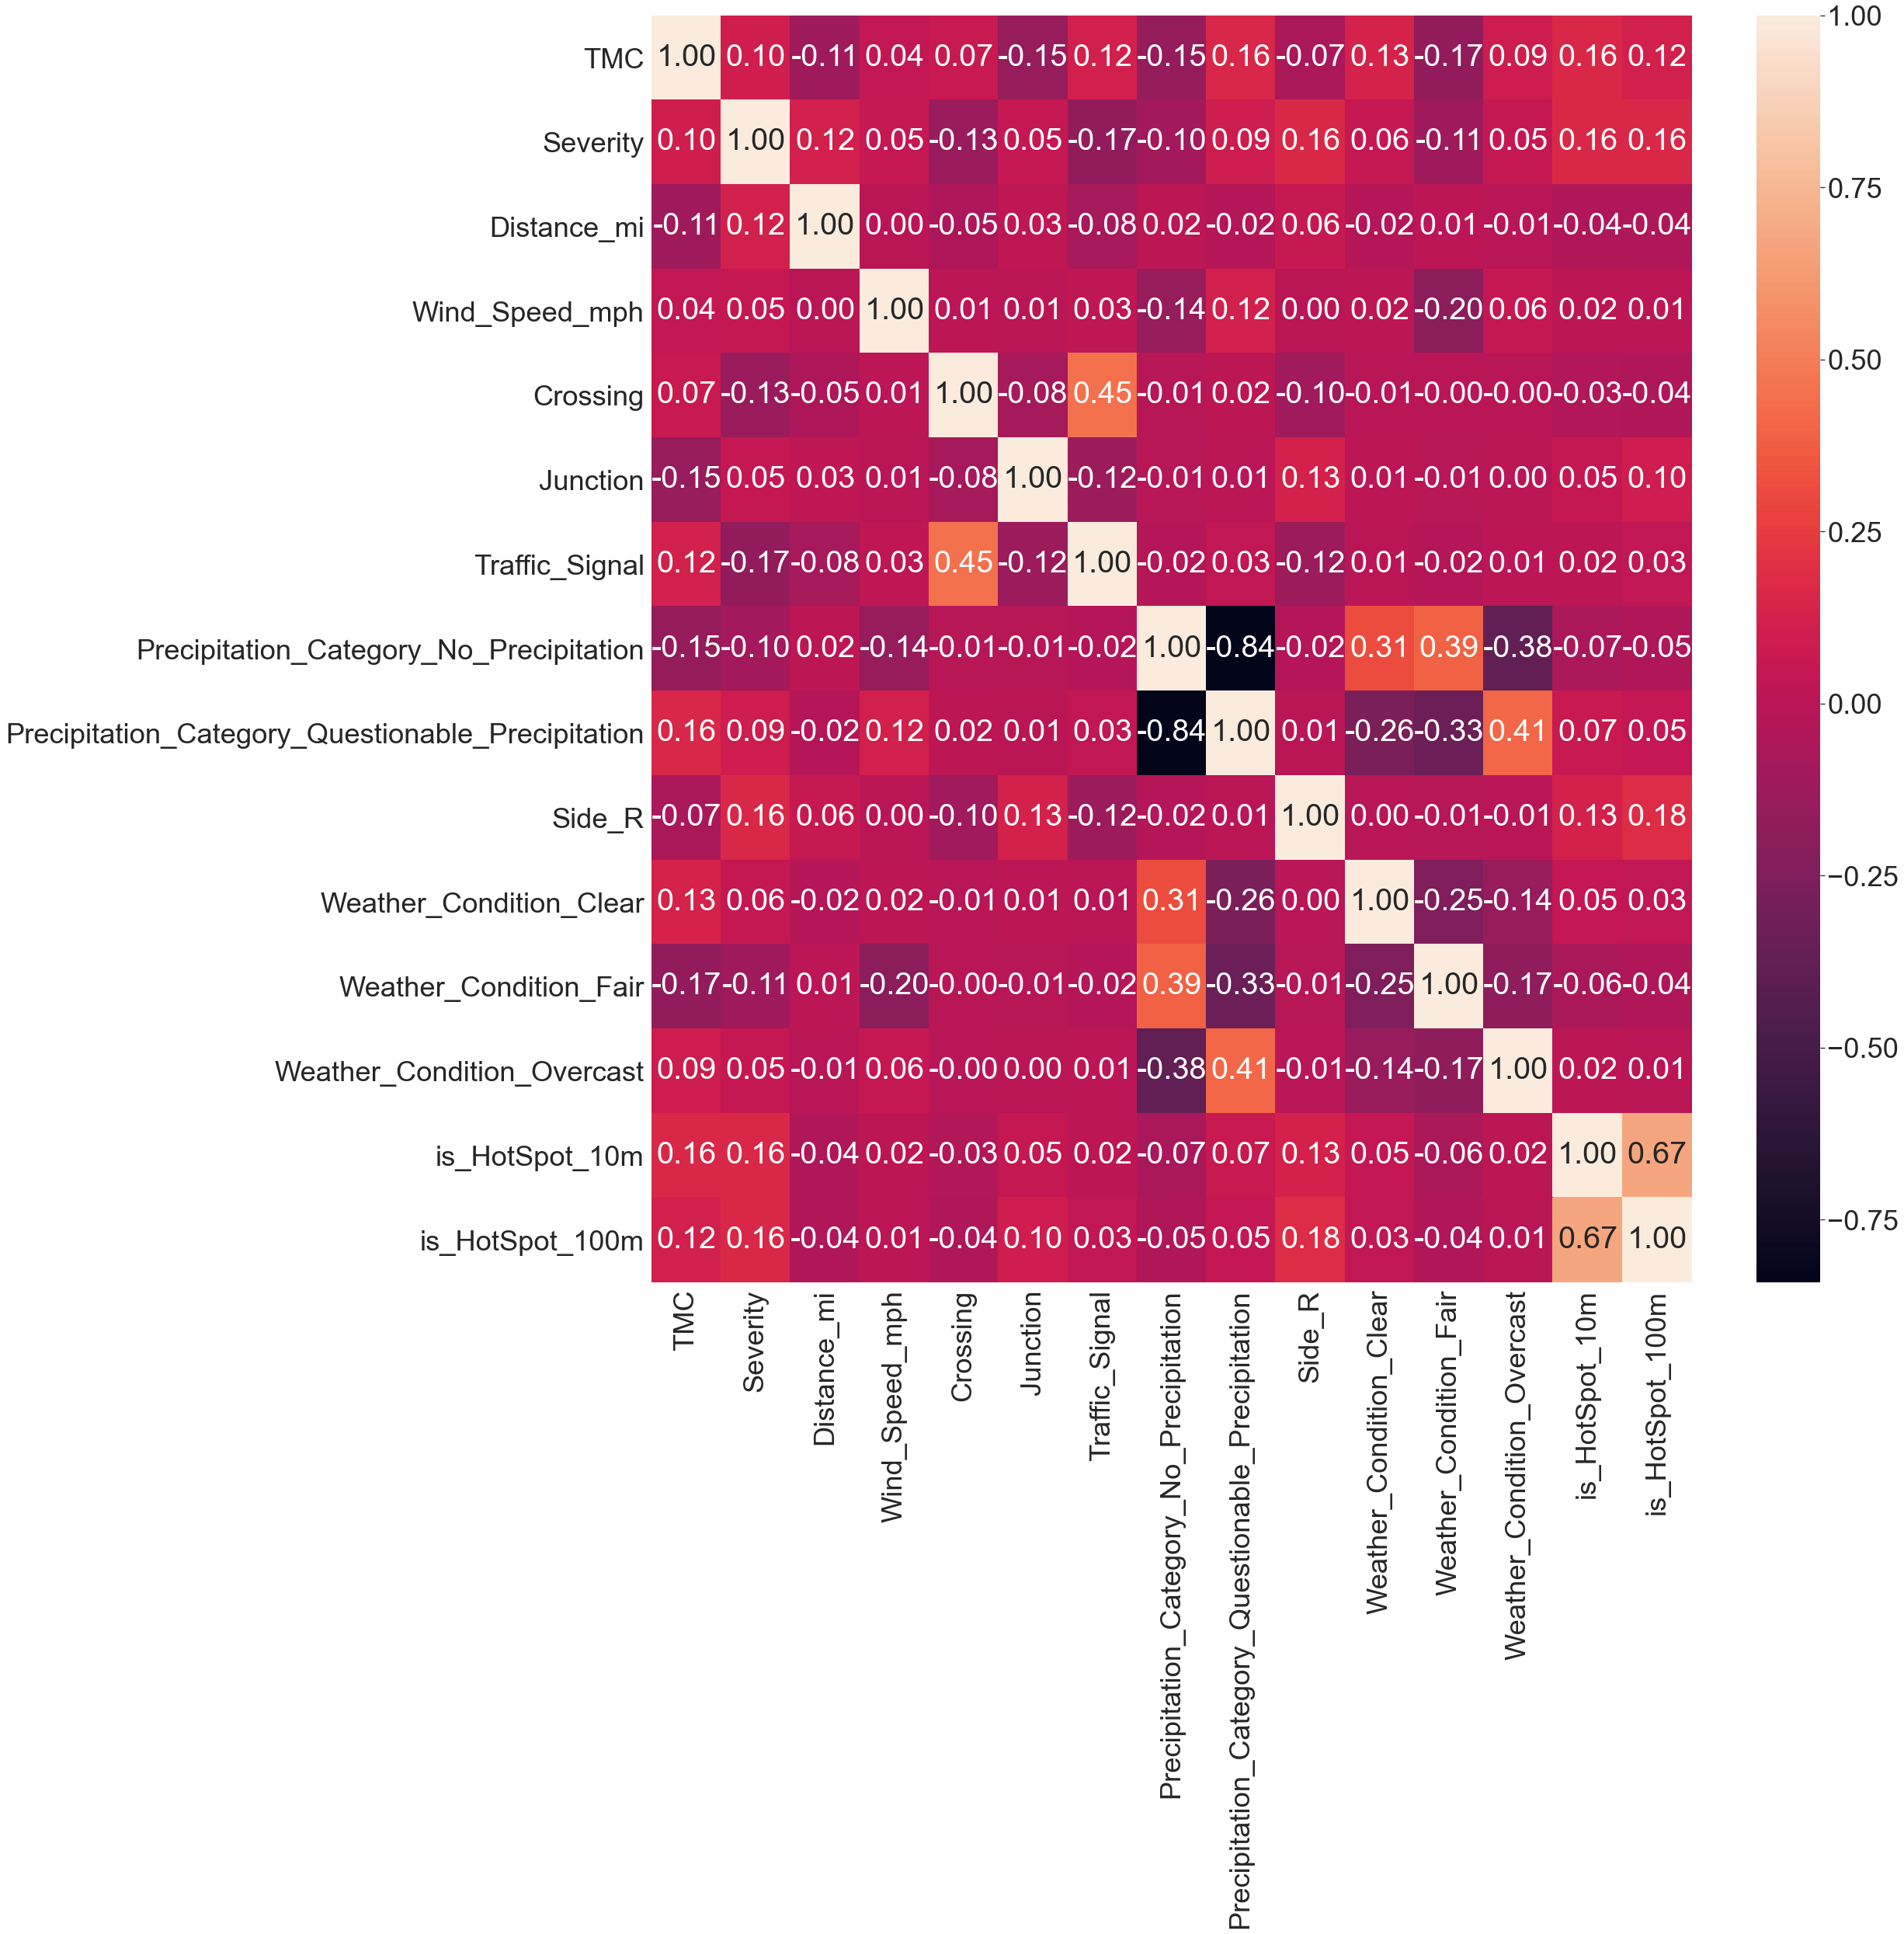

In [93]:
sns. set(font_scale=3.3)
sns.heatmap(df_ppt_cat_pred_Sev_only_correlated.corr(), annot = True, fmt = '.2f')

In [94]:
variables.drop(axis = 1, columns = [x for x in variables.columns if x not in correlated_values],
               inplace = True)

#### Providing matrices and standarization of them

In [95]:
features = variables.values.reshape(-1,variables.shape[1])

scaler = StandardScaler()
scaler.fit(features)
features = scaler.transform(features)

In [96]:
labels = df_ppt_cat_pred_Sev["Severity"].values.reshape(-1,1)
labels = np.ravel(labels)

#### Train test split

In [97]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = 0.2, shuffle = True)

In [98]:
print('Training Features Shape:', X_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Features Shape:', X_test.shape)
print('Testing Labels Shape:', y_test.shape)

Training Features Shape: (2971107, 14)
Training Labels Shape: (2971107,)
Testing Features Shape: (742777, 14)
Testing Labels Shape: (742777,)


In [99]:
X_train

array([[ 0.76495927, -0.20596859, -0.18907634, ..., -0.3078738 ,
        -0.44904144, -0.66250948],
       [-1.30725914,  2.31740035, -1.48694972, ..., -0.3078738 ,
        -0.44904144, -0.66250948],
       [-1.30725914, -0.21226599, -0.18907634, ..., -0.3078738 ,
        -0.44904144, -0.66250948],
       ...,
       [ 0.76495927, -0.21226599,  0.01783101, ..., -0.3078738 ,
         2.22696596,  1.50941235],
       [-1.30725914,  0.29782356,  0.24354812, ..., -0.3078738 ,
        -0.44904144, -0.66250948],
       [-1.30725914, -0.21226599,  0.95831897, ..., -0.3078738 ,
        -0.44904144, -0.66250948]])

#### Implementing multilayer-perceptron classifier

**As a rule of thumb we should define the following number of nodes on our hidden layer:**

- (Input_nodes + Output_nodes) / 2
- Input_nodes = number_of_variables = 14
- Output_loads = number of outcome classes = 3 -> Severity_1, 2 or 3. The 4 is given when we have neither 1 nor 2 nor 3
- Hence the hyperparameter for the classifier is (14+3)/2 = 8,5 -> 9

In [100]:
mlp_class = MLPClassifier(max_iter=10000, hidden_layer_sizes=(9,))

In [101]:
mlp_class.fit(X_train, y_train)

MLPClassifier(hidden_layer_sizes=(9,), max_iter=10000)

In [102]:
mlp_pred = mlp_class.predict(X_test)

In [103]:
result_model = len(mlp_pred[(mlp_pred /  y_test) ==1]) / len(y_test)

In [104]:
result_model

0.7725427685563769

#### The result seem to be ok but let's consider the accuracy with regard to Severity 4

In [105]:
df_ppt_cat_pred_Sev_only_correlated.Severity.value_counts().sum()

3713884

In [106]:
results = pd.DataFrame()
results["predictions"] = mlp_pred
results["labels"] = y_test

In [178]:
predictions_unbalanced_DS = [
round(100*len(results.loc[(results.labels == 1) & (results.predictions ==1)]) / len(y_test[y_test==1]),2),
round(100*len(results.loc[(results.labels == 2) & (results.predictions ==2)]) / len(y_test[y_test==2]),2),
round(100*len(results.loc[(results.labels == 3) & (results.predictions ==3)]) / len(y_test[y_test==3]),2), 
round(100*len(results.loc[(results.labels == 4) & (results.predictions ==4)]) / len(y_test[y_test==4]),2)]



print("Percantage of correct predictions in case of balanced data set for: \n \
Severity 1    {} \n \
Severity 2    {} \n \
Severity 3    {} \n \
Severity 4    {}".format(
    round(predictions_unbalanced_DS[0],2),
    round(predictions_unbalanced_DS[1],2),
    round(predictions_unbalanced_DS[2],2),
    round(predictions_unbalanced_DS[3],2)))

Percantage of correct predictions in case of balanced data set for: 
 Severity 1    88.96 
 Severity 2    22.5 
 Severity 3    77.53 
 Severity 4    87.74


#### It is clearly observable that we missed in almost 93,5% of cases! The model does not fullfill his function when it comes to capturing the severity 4 accidents. 

#### Furthermore if we compare our result with the mode baseline, we gain only slight enhencement of predictive capabilities

In [111]:
result_modeBaseline = df_ppt_cat.Severity.value_counts().values.max() / df_ppt_cat.Severity.value_counts().sum()

In [112]:
result_model - result_modeBaseline

0.05570993263581503

## b. Predictions using data set with precipitations as numerical variable

In [113]:
df_ppt_num_pred_Sev = df_ppt_num.drop(axis =1 , 
            columns = ["ID", "State", "Street", "City", "County", 
                       "Coordinates_10m", "Coordinates_100m", "Start_Lat", "Start_Lng"])

In [114]:
variables = df_ppt_num_pred_Sev.drop(axis = 1, columns = ["Severity", "Duration_minutes"])

#### Providing the values for correlations

In [115]:
correlations = df_ppt_num_pred_Sev.corr()['Severity']

#### I have decided to use only the variables which have at least 0.05 correlation with regard to severity

In [116]:
correlated_values = correlations.index[(correlations.values >= 0.05) | (correlations.values <= -0.05)]

In [117]:
variables.drop(axis = 1, columns = [x for x in variables.columns if x not in correlated_values],
               inplace = True)

In [118]:
variables.head()

,TMC,Distance_mi,Wind_Speed_mph,Crossing,Traffic_Signal,Side_R,Weather_Condition_Clear,Weather_Condition_Fair,is_HotSpot_10m,is_HotSpot_100m
0,1,0.01,3.5,0,0,1,0,0,0,0
1,1,0.01,4.6,0,0,1,0,0,0,0
2,1,0.01,4.6,0,0,1,0,0,0,1
3,1,0.01,4.6,0,1,0,0,0,0,0
4,1,0.00,4.6,0,0,1,0,0,0,0


#### Providing matrices and standarization of them

In [119]:
features = variables.values.reshape(-1,variables.shape[1])

scaler = StandardScaler()
scaler.fit(features)
features = scaler.transform(features)

In [120]:
labels = df_ppt_num_pred_Sev["Severity"].values.reshape(-1,1)
labels = np.ravel(labels)

#### Train test split

In [121]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = 0.2, shuffle = True)

In [122]:
print('Training Features Shape:', X_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Features Shape:', X_test.shape)
print('Testing Labels Shape:', y_test.shape)

Training Features Shape: (2200459, 10)
Training Labels Shape: (2200459,)
Testing Features Shape: (550115, 10)
Testing Labels Shape: (550115,)


#### Implementing multilayer-perceptron classifier

**As a rule of thumb we should define the following number of nodes on our hidden layer:**

- (Input_nodes + Output_nodes) / 2
- Input_nodes = number_of_variables = 10
- Output_loads = number of outcome classes = 3 -> Severity_1, 2 or 3. The 4 is given when we have neither 1 nor 2 or 3
- Hence the hyperparameter for the classifier is (10+3)/2 = 6,5 -> 7

In [123]:
mlp_class = MLPClassifier(max_iter=10000, hidden_layer_sizes=(7,))

In [124]:
mlp_class.fit(X_train, y_train)

MLPClassifier(hidden_layer_sizes=(7,), max_iter=10000)

In [125]:
mlp_pred = mlp_class.predict(X_test)

In [126]:
result_model = len(mlp_pred[(mlp_pred /  y_test) ==1]) / len(y_test)

In [127]:
result_model

0.7765103660143788

#### The result is almost the same as for the classifier in the point a. The problem with prediciting Severity 4 accidents remains

In [128]:
results = pd.DataFrame()
results["predictions"] = mlp_pred
results["labels"] = y_test

In [129]:
len(results.loc[(results.labels == 4) & (results.predictions !=4)]) / len(y_test[y_test==4])

0.9384473441412943

In [130]:
len(results.loc[(results.labels == 3) & (results.predictions !=3)]) / len(y_test[y_test==3])

0.5935812764155476

In [131]:
len(results.loc[(results.labels == 2) & (results.predictions !=2)]) / len(y_test[y_test==2])

0.07444226101028782

In [132]:
len(results.loc[(results.labels == 1) & (results.predictions !=1)]) / len(y_test[y_test==1])

1.0

#### It is clearly observable that we missed in over 94% of cases!

#### Comparison with baseline gives simillar conclusions as for the previous model

In [133]:
result_modeBaseline = df_ppt_num.Severity.value_counts().values.max() / df_ppt_num.Severity.value_counts().sum()

In [134]:
result_model - result_modeBaseline

0.03713742058553382

## c. Predictions using data set with precipitations as categorical variable plus balanced classes

In [135]:
df_ppt_cat_undersample = df_ppt_cat_pred_Sev

In [136]:
df_Severity_2 = df_ppt_cat_undersample.query("Severity == 2").sample(n
                                                                     =df_ppt_cat_undersample.Severity.value_counts().min())
df_Severity_3 = df_ppt_cat_undersample.query("Severity == 3").sample(n
                                                                     =df_ppt_cat_undersample.Severity.value_counts().min())
df_Severity_4 = df_ppt_cat_undersample.query("Severity == 4").sample(n
                                                                     =df_ppt_cat_undersample.Severity.value_counts().min())

In [137]:
df_ppt_cat_undersample = df_ppt_cat_undersample.query("Severity ==1").append(
    [df_Severity_2,df_Severity_3,df_Severity_4])

In [138]:
df_ppt_cat_undersample.reset_index(inplace = True)
df_ppt_cat_undersample.drop(columns = 'index', axis = 1, inplace = True)

In [139]:
df_ppt_cat_undersample

,TMC,Severity,Start_Time,Distance_mi,Temperature_F,Humidity_%,Pressure_in,Visibility_mi,Wind_Speed_mph,Amenity,...,Wind_Direction_South,Wind_Direction_VAR,Wind_Direction_Variable,Wind_Direction_W,Wind_Direction_WNW,Wind_Direction_WSW,Wind_Direction_West,Duration_minutes,is_HotSpot_10m,is_HotSpot_100m
0,1,1,2016-02-15 17:22:10,0.000,33.1,82.0,29.95,7.0,5.8,0,...,0,0,0,0,0,0,0,45.0,0,0
1,1,1,2016-02-24 07:59:51,0.000,46.0,86.0,29.46,7.0,11.5,0,...,0,0,0,0,0,0,0,30.0,0,0
2,1,1,2016-06-22 23:54:48,0.000,66.0,42.0,29.94,10.0,6.9,0,...,0,0,0,0,1,0,0,45.0,0,0
3,1,1,2016-12-26 18:32:07,0.010,48.9,54.0,30.29,10.0,8.1,1,...,0,0,0,0,0,0,0,45.0,0,0
4,1,1,2017-01-24 08:50:08,0.000,41.0,93.0,30.06,10.0,5.8,0,...,0,0,0,0,0,0,0,60.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114151,0,4,2017-02-14 10:44:35,0.527,35.6,70.0,30.00,10.0,5.8,0,...,0,0,0,0,0,0,0,360.0,0,0
114152,0,4,2016-10-17 12:41:51,1.945,70.9,79.0,29.59,10.0,11.5,0,...,0,0,0,0,0,0,0,360.0,0,0
114153,0,4,2017-01-12 02:12:13,2.954,42.8,100.0,29.92,10.0,12.7,0,...,0,0,0,0,0,0,0,360.0,0,0
114154,0,4,2019-05-02 06:37:41,0.372,55.0,100.0,29.81,1.0,0.0,0,...,0,0,0,0,0,0,0,29.0,0,0


In [140]:
variables = df_ppt_cat_undersample.drop(axis = 1, columns = ["Severity", "Duration_minutes"])

In [141]:
correlations = df_ppt_cat_undersample.corr()['Severity']

#### I have decided to use only the variables which have at least 0.05 correlation with regard to severity

In [142]:
correlated_values = correlations.index[(correlations.values >= 0.05) | (correlations.values <= -0.05)]

C:\Users\x\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater_equal
  """Entry point for launching an IPython kernel.
C:\Users\x\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less_equal
  """Entry point for launching an IPython kernel.


In [143]:
variables.drop(axis = 1, columns = [x for x in variables.columns if x not in correlated_values],
               inplace = True)

In [144]:
variables.head()

,TMC,Distance_mi,Temperature_F,Humidity_%,Pressure_in,Visibility_mi,Crossing,Station,Traffic_Signal,After_Sunset,...,Wind_Direction_E,Wind_Direction_East,Wind_Direction_N,Wind_Direction_North,Wind_Direction_S,Wind_Direction_South,Wind_Direction_VAR,Wind_Direction_Variable,Wind_Direction_W,Wind_Direction_West
0,1,0.00,33.1,82.0,29.95,7.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0.00,46.0,86.0,29.46,7.0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,1,0.00,66.0,42.0,29.94,10.0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,1,0.01,48.9,54.0,30.29,10.0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
4,1,0.00,41.0,93.0,30.06,10.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Providing matrices and standarization of them

In [145]:
features = variables.values.reshape(-1,variables.shape[1])

scaler = StandardScaler()
scaler.fit(features)
features = scaler.transform(features)

In [146]:
labels = df_ppt_cat_undersample["Severity"].values.reshape(-1,1)
labels = np.ravel(labels)

#### Train test split

In [147]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = 0.2, shuffle = True)

In [148]:
print('Training Features Shape:', X_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Features Shape:', X_test.shape)
print('Testing Labels Shape:', y_test.shape)

Training Features Shape: (91324, 31)
Training Labels Shape: (91324,)
Testing Features Shape: (22832, 31)
Testing Labels Shape: (22832,)


#### Implementing multilayer-perceptron classifier

**As a rule of thumb we should define the following number of nodes on our hidden layer:**

- (Input_nodes + Output_nodes) / 2
- Input_nodes = number_of_variables = 14
- Output_loads = number of outcome classes = 3 -> Severity_1, 2 or 3. The 4 is given when we have neither 1 nor 2 or 3
- Hence the hyperparameter for the classifier is (14+3)/2 = 8,5 -> 9

In [149]:
mlp_class = MLPClassifier(max_iter=10000, hidden_layer_sizes=(9,))

In [150]:
mlp_class.fit(X_train, y_train)

MLPClassifier(hidden_layer_sizes=(9,), max_iter=10000)

In [151]:
mlp_pred = mlp_class.predict(X_test)

In [152]:
result_model = len(mlp_pred[(mlp_pred /  y_test) ==1]) / len(y_test)

In [153]:
result_model

0.6886387526278906

#### The result seem to be ok but let's consider the accuracy with regard to Severity 4

In [154]:
results = pd.DataFrame()
results["predictions"] = mlp_pred
results["labels"] = y_test

In [155]:
len(results.loc[(results.labels == 4) & (results.predictions !=4)]) / len(y_test[y_test==4])

0.12256022507473184

In [156]:
len(results.loc[(results.labels == 3) & (results.predictions !=3)]) / len(y_test[y_test==3])

0.22467349099894104

In [157]:
len(results.loc[(results.labels == 2) & (results.predictions !=2)]) / len(y_test[y_test==2])

0.7749742533470649

In [158]:
len(results.loc[(results.labels == 1) & (results.predictions !=1)]) / len(y_test[y_test==1])

0.11038386697328852

In [179]:
predictions_balanced_DS = [
round(100*len(results.loc[(results.labels == 1) & (results.predictions ==1)]) / len(y_test[y_test==1]),2),
round(100*len(results.loc[(results.labels == 2) & (results.predictions ==2)]) / len(y_test[y_test==2]),2),
round(100*len(results.loc[(results.labels == 3) & (results.predictions ==3)]) / len(y_test[y_test==3]),2), 
round(100*len(results.loc[(results.labels == 4) & (results.predictions ==4)]) / len(y_test[y_test==4]),2)]

print("Percantage of correct predictions in case of balanced data set for: \n \
Severity 1    {} \n \
Severity 2    {} \n \
Severity 3    {} \n \
Severity 4    {}".format(
    round(predictions_balanced_DS[0],2),
    round(predictions_balanced_DS[1],2),
    round(predictions_balanced_DS[2],2),
    round(predictions_balanced_DS[3],2)))

Percantage of correct predictions in case of balanced data set for: 
 Severity 1    88.96 
 Severity 2    22.5 
 Severity 3    77.53 
 Severity 4    87.74


In [160]:
predictions_balanced_DS

[11.04, 77.5, 22.47, 12.26]

In [161]:
predictions_unbalanced_DS

[100.0, 9.14, 52.17, 89.72]

In [162]:
classes = ["Severity Class 1", "Severity Class 2", "Severity Class 3", "Severity Class 4"]

In [176]:
def add_value_labels(ax, spacing=5):
    """Add labels to the end of each bar in a bar chart.

    Arguments:
        ax (matplotlib.axes.Axes): The matplotlib object containing the axes
            of the plot to annotate.
        spacing (int): The distance between the labels and the bars.
    """

    # For each bar: Place a label
    for rect in ax.patches:
        # Get X and Y placement of label from rect.
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        # Number of points between bar and label. Change to your liking.
        space = spacing
        # Vertical alignment for positive values
        va = 'bottom'

        # If value of bar is negative: Place label below bar
        if y_value < 0:
            # Invert space to place label below
            space *= -1
            # Vertically align label at top
            va = 'top'

        # Use Y value as label and format number with one decimal place
        label = "{:.1f}".format(y_value)

        # Create annotation
        ax.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            xytext=(0, space),          # Vertically shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            ha='center',                # Horizontally center label
            va=va)                      # Vertically align label differently for
                                        # positive and negative values.


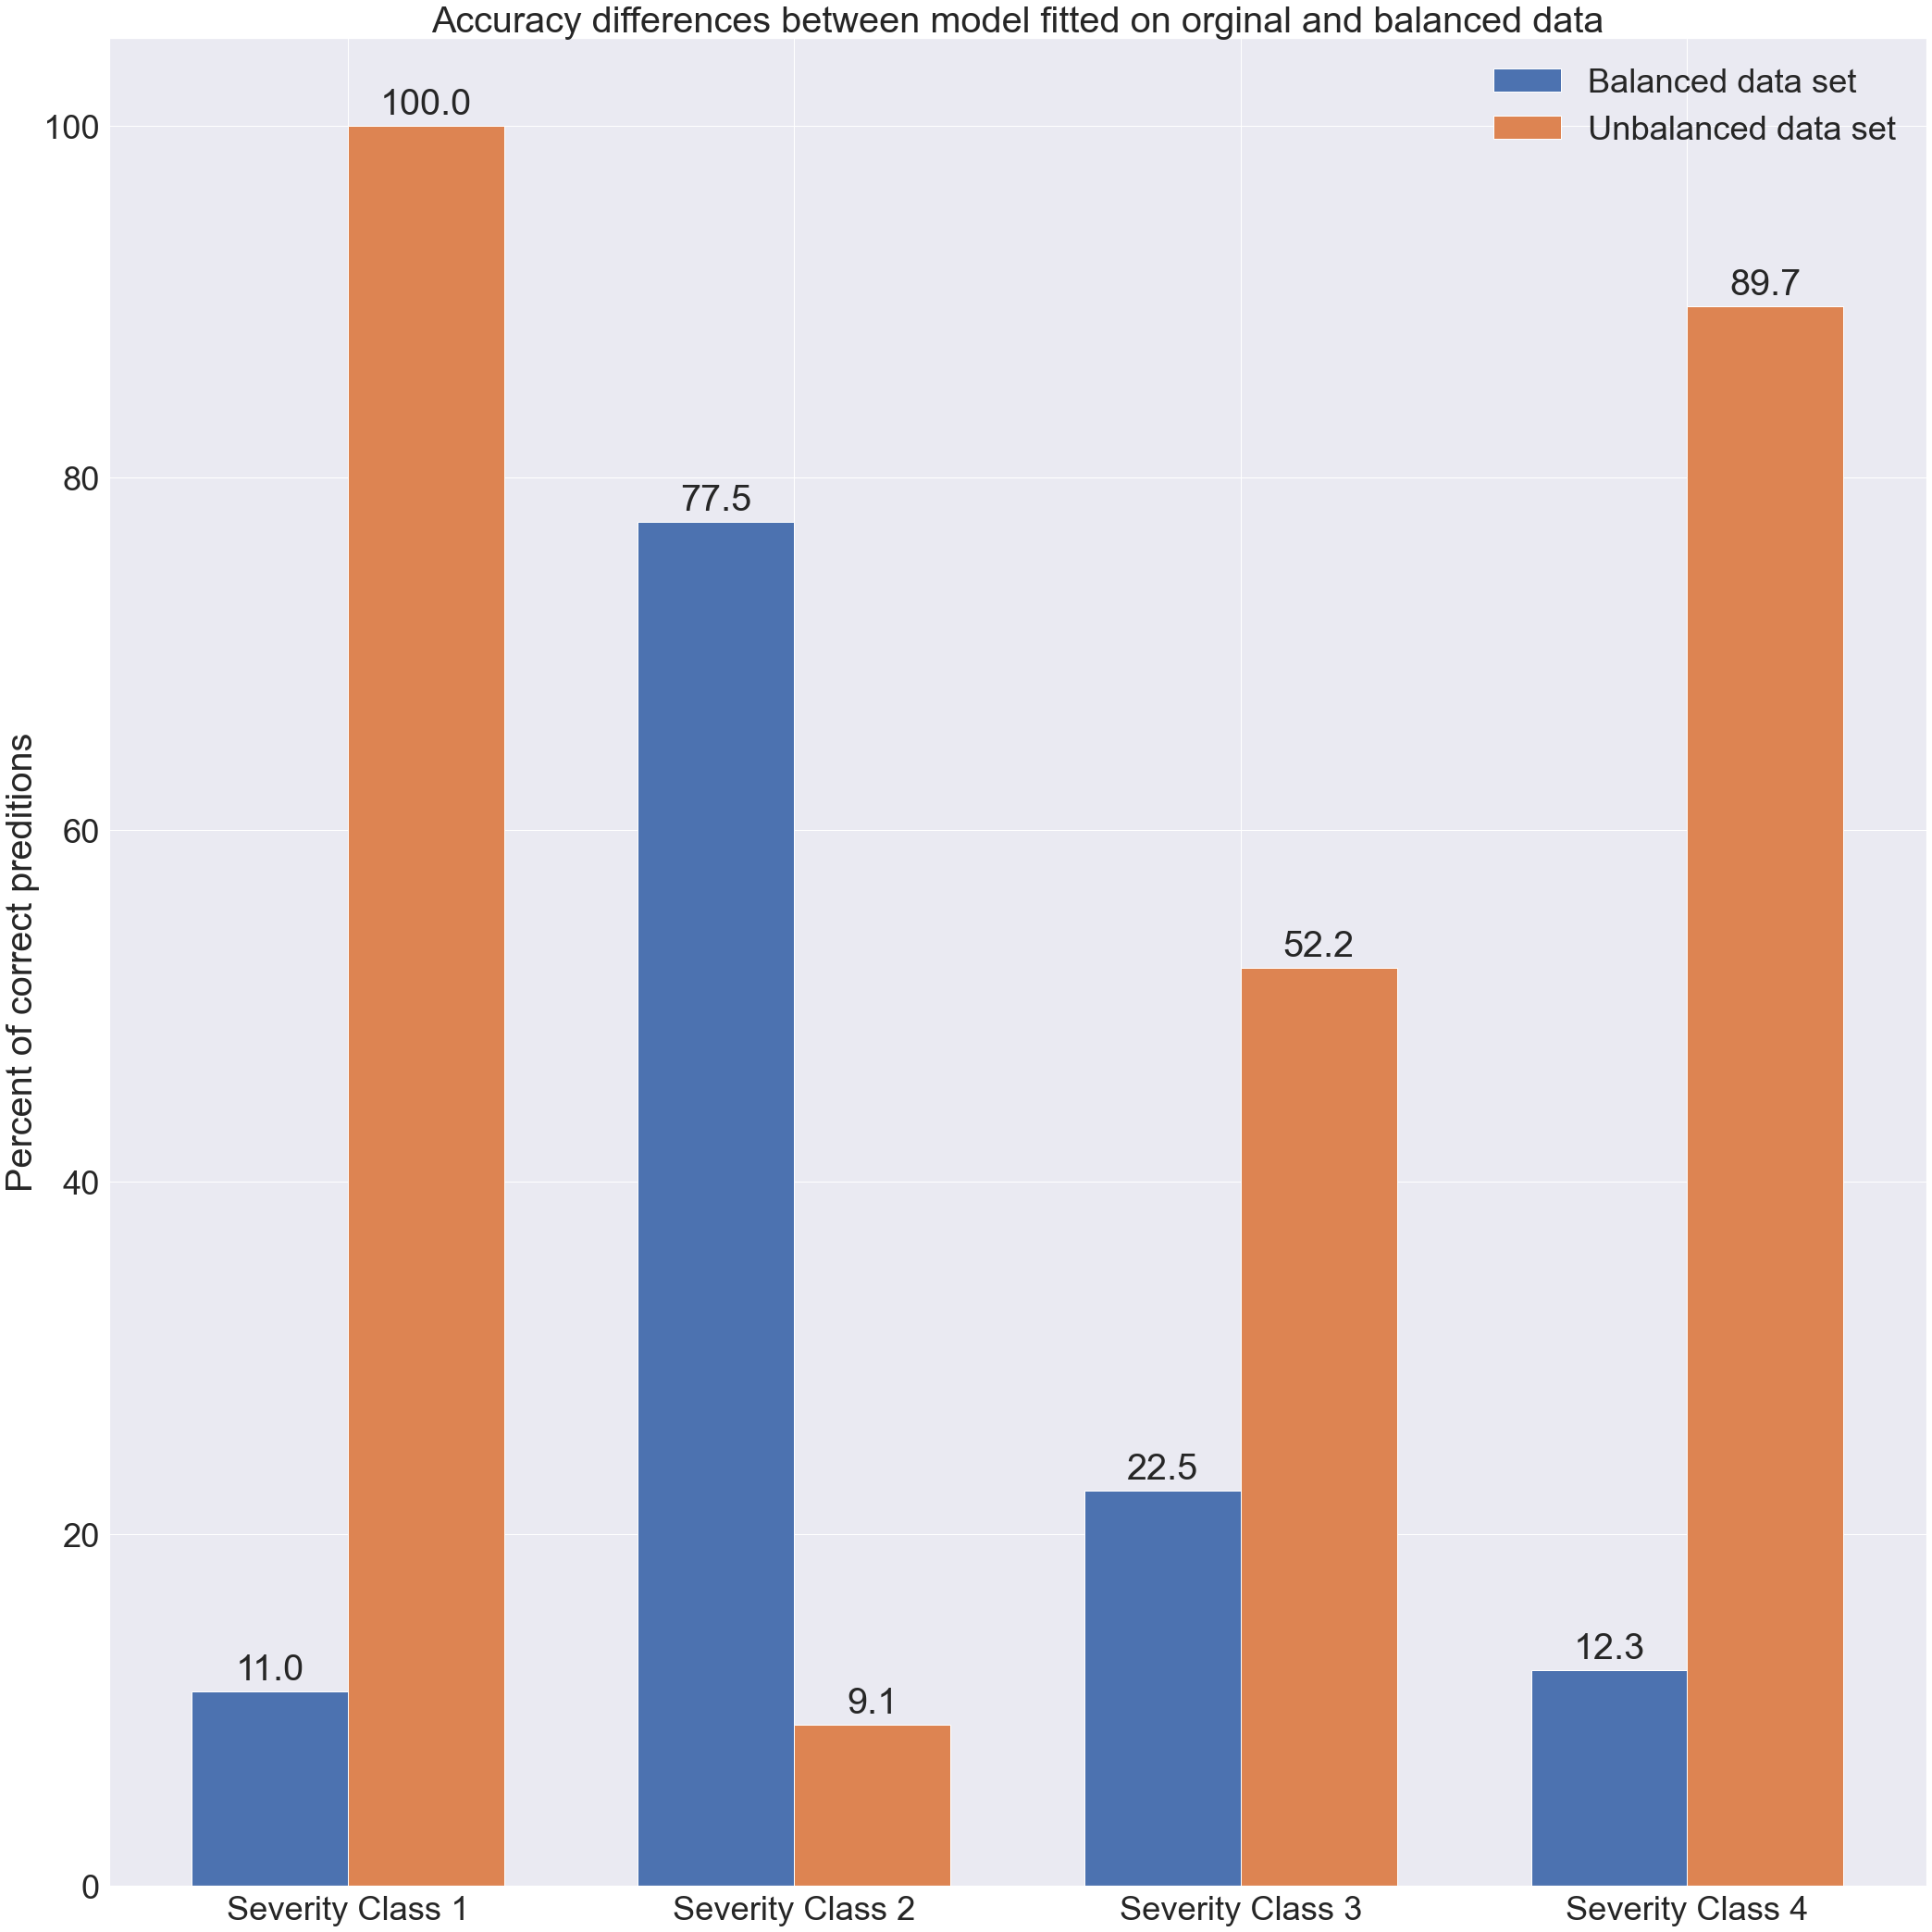

In [177]:
x = np.arange(len(classes))
width = 0.35  

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, predictions_balanced_DS , width, label='Balanced data set')
rects2 = ax.bar(x + width/2, predictions_unbalanced_DS, width, label='Unbalanced data set')


ax.set_ylabel('Percent of correct preditions')
ax.set_title('Accuracy differences between model fitted on orginal and balanced data')
ax.set_xticks(x)
ax.set_xticklabels(classes)
ax.legend()
add_value_labels(ax)
#ax.bar_label(rects1, padding=3)
#ax.bar_label(rects2, padding=3)

fig.tight_layout()



plt.show()

#### It is clearly observable that we missed in almost 93,5% of cases! The model does not fullfill his function when it comes to capturing the severity 4 accidents. 

#### Furthermore if we compare our result with the mode baseline, we gain only slight enhencement of predictive capabilities

In [163]:
result_modeBaseline_undersampled = df_ppt_cat_undersample.Severity.value_counts().values.max() / df_ppt_cat_undersample.Severity.value_counts().sum()

In [164]:
result_model - result_modeBaseline_undersampled

0.46342852137351087

#### Properly made predictions

### Prediction model for calculating the duration time in minutes



In [166]:
correlations = df.corr()['Duration_minutes']

KeyError: 'Duration_minutes'

In [ ]:
correlated_values = correlations.index[(correlations.values >= 0.12) | (correlations.values <= -0.12)]

In [ ]:
variables = df.drop(axis = 1, columns = ["Severity", "Duration_minutes"])

In [ ]:
variables.drop(axis = 1, columns = [x for x in variables.columns if x not in correlated_values],
               inplace = True)

In [ ]:
features = variables.values.reshape(-1,variables.shape[1])

#scaler = StandardScaler()
#scaler.fit(features)
#features = scaler.transform(features)

In [ ]:
labels = df["Duration_minutes"].values.reshape(-1,1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = 0.2, shuffle = True)

In [ ]:
print('Training Features Shape:', X_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Features Shape:', X_test.shape)
print('Testing Labels Shape:', y_test.shape)

In [ ]:
lr = LinearRegression(normalize = True)

In [ ]:
lr.fit(X_train, y_train)

In [ ]:
y_pred = lr.predict(X_test)

In [ ]:
lr.score(X_test, y_test)

In [ ]:
plt.figure(figsize = (6,6))

plt.scatter(y_test, y_pred, s = 80, facecolors = 'none', edgecolors = 'r')

In [ ]:
np.median(abs(y_pred - y_test))

### Model score when accuracy of 1,5 or 10 minutes are required

In [ ]:
def round_func(x, base = 1):
    return base * np.round(x/base)

In [ ]:
y_pred_rounded_to_1 = round_func(y_pred)
y_test_rounded_to_1 = round_func(y_test)

In [ ]:
y_pred_rounded_to_5 = round_func(y_pred, base = 5)
y_test_rounded_to_5 = round_func(y_test, base = 5)

In [ ]:
y_pred_rounded_to_10 = round_func(y_pred, base = 10)
y_test_rounded_to_10 = round_func(y_test, base = 10)

In [ ]:
y_pred_rounded_to_15 = round_func(y_pred, base = 15)
y_test_rounded_to_15 = round_func(y_test, base = 15)

In [ ]:
y_pred_rounded_to_20 = round_func(y_pred, base = 20)
y_test_rounded_to_20 = round_func(y_test, base = 20)

In [ ]:
y_pred_rounded_to_30 = round_func(y_pred, base = 30)
y_test_rounded_to_30 = round_func(y_test, base = 30)

In [ ]:
(y_pred_rounded_to_1 / y_test_rounded_to_1 == 1).mean()

In [ ]:
(y_pred_rounded_to_5 / y_test_rounded_to_5 == 1).mean()

In [ ]:
(y_pred_rounded_to_10 == y_test_rounded_to_10).mean()

In [ ]:
(y_pred_rounded_to_15 == y_test_rounded_to_15).mean()

In [ ]:
(y_pred_rounded_to_20 == y_test_rounded_to_20).mean()

In [ ]:
(y_pred_rounded_to_30 == y_test_rounded_to_30).mean()

## Answering the question which facilities characterize the accidents' hot spots